# Evaluation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pickle

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loss

This model has two loss functions. One for the classification subnet, the other for the bounding box regression subnet.

Plot the total, regression and classification losses with validation and save figs.

In [2]:
def plot_loss_history(history_path):
    with (open(history_path, 'rb')) as file:
        history = pickle.load(file)
    
    # validation losses
    val_loss = history['val_loss']
    val_regression_loss = history['val_regression_loss']
    val_classification_loss = history['val_classification_loss']

    # training losses
    loss = history['loss']
    regression_loss = history['regression_loss']
    classification_loss = history['classification_loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.savefig('./history/history_30_loss.png')
    plt.show()

    plt.title('Classification Loss')
    plt.plot(val_classification_loss, 'r', regression_loss, 'b')
    plt.savefig('./history/history_30_cl_loss.png')
    plt.show()

    plt.title('Regression Loss')
    plt.plot(val_regression_loss, 'r', regression_loss, 'b')
    plt.savefig('./history/history_30_reg_loss.png')
    plt.show()

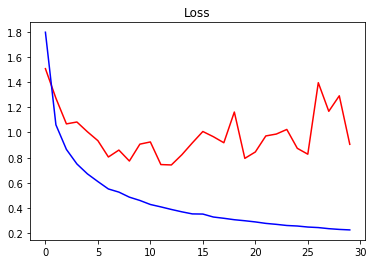

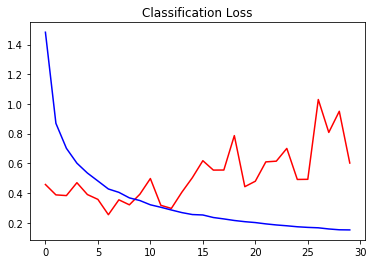

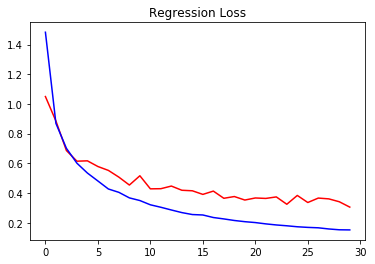

In [3]:
plot_loss_history('./history/history.pkl')

## AP/AR

This section loads the trained model and creates a submission text file for the VIVA Hand Detection Challenge evaluation kit to evaluate.

In [19]:
model = keras.models.load_model('./snapshots/resnet50_csv_25.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/home/ubuntu/.local/lib/python3.6/site-packages/Keras-2.1.2-py3.6.egg/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
test_generator = keras.preprocessing.image.ImageDataGenerator()
csv_test_generator = CSVGenerator(
    './data/test.csv',
    './data/classes.csv',
    test_generator,
    batch_size=1,
)

In [21]:
def get_detections_for_image(image, model, generator):
    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    detections[0, :, :4] /= scale
    
    return detections

Test prediction on a random image from the test dataset.

processing time:  0.7222781181335449


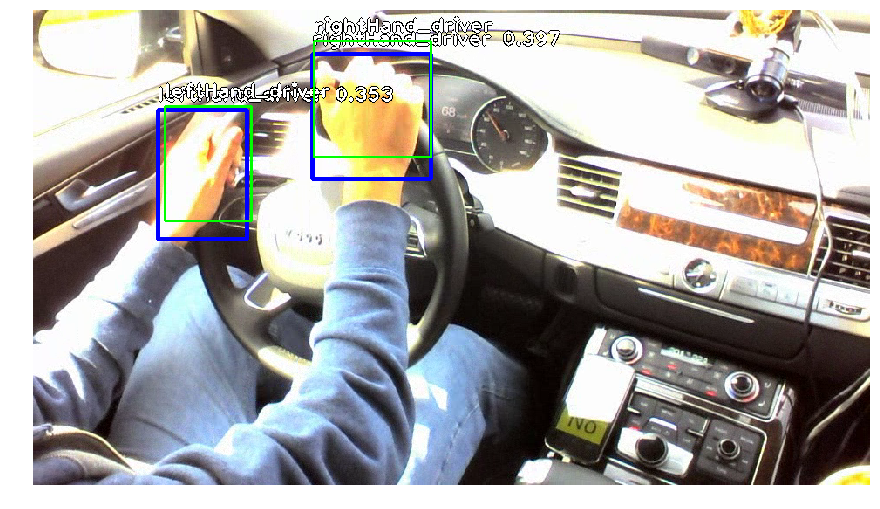

In [22]:
from random import randint

test_index = randint(0,csv_test_generator.size())
# load image
image = csv_test_generator.load_image(test_index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
detections = get_detections_for_image(image, model, csv_test_generator)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(csv_test_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

annotations = csv_test_generator.load_annotations(test_index)

# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(csv_test_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

A single detection example:

In [23]:
print(detections[0,100,:])

[ -1.72980766e+01   1.21526749e+02   2.80262146e+01   1.96311020e+02
   2.11658143e-03   1.72616809e-03   1.15793955e-03   9.24331835e-04]


## Submission



In [24]:
entries = []

for index in range(csv_test_generator.size()):
    # load image
    image = csv_test_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    detections = get_detections_for_image(image, model, csv_test_generator)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.25:
            continue
        _, filename = os.path.split(csv_test_generator.image_path(index))
        filename, _ = os.path.splitext(filename)
        
        b = detections[0, idx, :4].astype(int)
        
        if b[0] < b[2]:
            x, y, w, h = float(b[0]), float(b[1]), float(b[2]-b[0]), float(b[3]-b[1])
        else:
            x, y, w, h = float(b[1]), float(b[0]), float(b[0]-b[2]), float(b[1]-b[3])
            
        entry = '{} {} {} {} {} {} -1 -1 -1'.format(filename, x, y, w, h, score)
        print(entry)
        entries.append(entry)

print('Found {} entries.'.format(len(entries)))
submission = '\n'.join(entries)
with open('submission.txt', 'w') as file:
    file.write(submission)

processing time:  0.22670316696166992
10L_0015700_Q_1_4_5 476.0 354.0 75.0 67.0 0.2768803834915161 -1 -1 -1
processing time:  0.20144319534301758
10L_0015701_Q_1_4_5 476.0 354.0 75.0 66.0 0.2741163372993469 -1 -1 -1
processing time:  0.1839900016784668
10L_0015702_Q_1_4_5 476.0 354.0 75.0 66.0 0.279450923204422 -1 -1 -1
processing time:  0.18178057670593262
10L_0015703_Q_1_4_5 476.0 354.0 75.0 67.0 0.27807655930519104 -1 -1 -1
processing time:  0.18817710876464844
10L_0015704_Q_1_4_5 476.0 354.0 75.0 67.0 0.29259368777275085 -1 -1 -1
processing time:  0.18692302703857422
10L_0015705_Q_1_4_5 476.0 354.0 75.0 66.0 0.279575914144516 -1 -1 -1
processing time:  0.18166756629943848
10L_0015707_Q_1_4_5 476.0 354.0 75.0 67.0 0.2902490794658661 -1 -1 -1
processing time:  0.18120932579040527
10L_0015708_Q_1_4_5 476.0 354.0 75.0 66.0 0.2726627290248871 -1 -1 -1
processing time:  0.18173813819885254
10L_0015709_Q_1_4_5 475.0 354.0 76.0 67.0 0.2671721875667572 -1 -1 -1
processing time:  0.184780597

processing time:  0.18097639083862305
10L_0015766_Q_1_4_5 475.0 353.0 76.0 68.0 0.328077495098114 -1 -1 -1
processing time:  0.18330669403076172
10L_0015767_Q_1_4_5 475.0 353.0 76.0 68.0 0.29383695125579834 -1 -1 -1
processing time:  0.18853068351745605
10L_0015768_Q_1_4_5 475.0 353.0 76.0 68.0 0.29447945952415466 -1 -1 -1
processing time:  0.1888716220855713
10L_0015770_Q_1_4_5 475.0 354.0 76.0 67.0 0.3073888421058655 -1 -1 -1
10L_0015770_Q_1_4_5 216.0 265.0 87.0 79.0 0.2714213728904724 -1 -1 -1
processing time:  0.18239712715148926
10L_0015771_Q_1_4_5 475.0 354.0 76.0 67.0 0.303844153881073 -1 -1 -1
10L_0015771_Q_1_4_5 216.0 265.0 87.0 79.0 0.2559213638305664 -1 -1 -1
processing time:  0.18012690544128418
10L_0015772_Q_1_4_5 475.0 354.0 76.0 67.0 0.2942655384540558 -1 -1 -1
10L_0015772_Q_1_4_5 216.0 266.0 87.0 78.0 0.2591777741909027 -1 -1 -1
processing time:  0.18121623992919922
10L_0015773_Q_1_4_5 475.0 353.0 76.0 68.0 0.2931390106678009 -1 -1 -1
10L_0015773_Q_1_4_5 216.0 264.0 85.

processing time:  0.1845076084136963
10L_0015839_Q_1_4_5 475.0 354.0 76.0 68.0 0.32339024543762207 -1 -1 -1
processing time:  0.1853792667388916
10L_0015840_Q_1_4_5 475.0 354.0 76.0 67.0 0.30083608627319336 -1 -1 -1
processing time:  0.18765687942504883
10L_0015841_Q_1_4_5 475.0 354.0 75.0 67.0 0.3227546513080597 -1 -1 -1
processing time:  0.18957805633544922
10L_0015842_Q_1_4_5 475.0 354.0 76.0 66.0 0.3086991608142853 -1 -1 -1
processing time:  0.19121098518371582
10L_0015843_Q_1_4_5 475.0 354.0 76.0 66.0 0.31618255376815796 -1 -1 -1
processing time:  0.18377470970153809
10L_0015844_Q_1_4_5 475.0 353.0 76.0 67.0 0.3198121190071106 -1 -1 -1
processing time:  0.18607616424560547
10L_0015845_Q_1_4_5 475.0 354.0 76.0 67.0 0.3171292543411255 -1 -1 -1
10L_0015845_Q_1_4_5 366.0 306.0 66.0 79.0 0.2566627562046051 -1 -1 -1
processing time:  0.19218206405639648
10L_0015847_Q_1_4_5 475.0 354.0 76.0 66.0 0.30898451805114746 -1 -1 -1
processing time:  0.18977618217468262
10L_0015848_Q_1_4_5 475.0 

processing time:  0.18502402305603027
10L_0015909_Q_1_4_5 475.0 353.0 76.0 68.0 0.2949678599834442 -1 -1 -1
10L_0015909_Q_1_4_5 368.0 316.0 54.0 79.0 0.2911120653152466 -1 -1 -1
processing time:  0.18425369262695312
10L_0015910_Q_1_4_5 475.0 353.0 76.0 68.0 0.2803528904914856 -1 -1 -1
10L_0015910_Q_1_4_5 368.0 316.0 54.0 79.0 0.2781714200973511 -1 -1 -1
processing time:  0.18440771102905273
10L_0015911_Q_1_4_5 370.0 316.0 52.0 78.0 0.2934708893299103 -1 -1 -1
10L_0015911_Q_1_4_5 475.0 353.0 76.0 68.0 0.2664429247379303 -1 -1 -1
processing time:  0.18384289741516113
10L_0015912_Q_1_4_5 370.0 316.0 53.0 78.0 0.3411823511123657 -1 -1 -1
10L_0015912_Q_1_4_5 475.0 353.0 76.0 68.0 0.26497241854667664 -1 -1 -1
processing time:  0.18422770500183105
10L_0015913_Q_1_4_5 371.0 316.0 50.0 76.0 0.3562193512916565 -1 -1 -1
10L_0015913_Q_1_4_5 476.0 354.0 75.0 66.0 0.2539122700691223 -1 -1 -1
processing time:  0.18442964553833008
10L_0015914_Q_1_4_5 371.0 315.0 50.0 78.0 0.41153550148010254 -1 -1 -1


processing time:  0.18472647666931152
10L_0015992_Q_1_4_5 475.0 354.0 76.0 67.0 0.29152312874794006 -1 -1 -1
processing time:  0.1849217414855957
10L_0015993_Q_1_4_5 320.0 303.0 69.0 85.0 0.3216627538204193 -1 -1 -1
10L_0015993_Q_1_4_5 475.0 355.0 76.0 66.0 0.2737754285335541 -1 -1 -1
processing time:  0.18644332885742188
10L_0015994_Q_1_4_5 308.0 297.0 57.0 83.0 0.3774169385433197 -1 -1 -1
10L_0015994_Q_1_4_5 475.0 354.0 76.0 67.0 0.28223705291748047 -1 -1 -1
processing time:  0.19145965576171875
10L_0015995_Q_1_4_5 280.0 297.0 63.0 72.0 0.42345014214515686 -1 -1 -1
10L_0015995_Q_1_4_5 475.0 354.0 76.0 67.0 0.30550897121429443 -1 -1 -1
processing time:  0.19712519645690918
10L_0016059_Q_1_4_5 253.0 232.0 83.0 103.0 0.41283664107322693 -1 -1 -1
processing time:  0.1928567886352539
processing time:  0.1833510398864746
processing time:  0.1849822998046875
processing time:  0.18923282623291016
processing time:  0.18980765342712402
processing time:  0.18605828285217285
processing time:  0.

processing time:  0.1870558261871338
10L_0016159_Q_1_4_5 174.0 251.0 111.0 86.0 0.27999448776245117 -1 -1 -1
processing time:  0.182600736618042
processing time:  0.18230772018432617
10L_0016161_Q_1_4_5 171.0 249.0 109.0 88.0 0.30836722254753113 -1 -1 -1
processing time:  0.18631196022033691
10L_0016166_Q_1_4_5 304.0 200.0 85.0 116.0 0.2757147550582886 -1 -1 -1
processing time:  0.1875922679901123
processing time:  0.18837189674377441
processing time:  0.1894080638885498
processing time:  0.1954054832458496
processing time:  0.19173002243041992
processing time:  0.18402504920959473
processing time:  0.18608665466308594
processing time:  0.1919388771057129
processing time:  0.19300246238708496
processing time:  0.19071006774902344
processing time:  0.18415141105651855
10L_0016180_Q_1_4_5 313.0 213.0 87.0 115.0 0.2616679072380066 -1 -1 -1
processing time:  0.18062663078308105
10L_0016181_Q_1_4_5 271.0 222.0 84.0 112.0 0.5218592882156372 -1 -1 -1
processing time:  0.18399453163146973
10L_

processing time:  0.2026503086090088
14_0000163_0_0_0_3 417.0 898.0 226.0 174.0 0.7928000688552856 -1 -1 -1
14_0000163_0_0_0_3 23.0 107.0 339.0 222.0 0.461354523897171 -1 -1 -1
processing time:  0.20516729354858398
14_0000164_0_0_0_3 456.0 951.0 236.0 119.0 0.6838213801383972 -1 -1 -1
14_0000164_0_0_0_3 37.0 99.0 354.0 218.0 0.45381152629852295 -1 -1 -1
processing time:  0.21152901649475098
14_0000166_0_0_0_3 468.0 964.0 228.0 109.0 0.6420047283172607 -1 -1 -1
14_0000166_0_0_0_3 46.0 94.0 353.0 214.0 0.38602688908576965 -1 -1 -1
processing time:  0.2130293846130371
14_0000167_0_0_0_3 480.0 978.0 212.0 102.0 0.471731573343277 -1 -1 -1
14_0000167_0_0_0_3 59.0 89.0 364.0 207.0 0.4071018099784851 -1 -1 -1
processing time:  0.21022701263427734
14_0000168_0_0_0_3 479.0 979.0 210.0 101.0 0.5590721368789673 -1 -1 -1
14_0000168_0_0_0_3 68.0 78.0 359.0 218.0 0.5040547251701355 -1 -1 -1
processing time:  0.20406246185302734
14_0000170_0_0_0_3 95.0 79.0 354.0 210.0 0.6115216612815857 -1 -1 -1
14_0

processing time:  0.20912790298461914
14_0000235_0_0_0_3 603.0 925.0 274.0 149.0 0.5675486922264099 -1 -1 -1
14_0000235_0_0_0_3 78.0 97.0 379.0 236.0 0.5419186949729919 -1 -1 -1
processing time:  0.20679593086242676
14_0000236_0_0_0_3 599.0 939.0 258.0 139.0 0.7283509969711304 -1 -1 -1
14_0000236_0_0_0_3 78.0 97.0 380.0 237.0 0.5231456756591797 -1 -1 -1
processing time:  0.2058091163635254
14_0000238_0_0_0_3 596.0 954.0 241.0 124.0 0.5735776424407959 -1 -1 -1
14_0000238_0_0_0_3 77.0 91.0 379.0 245.0 0.4832839071750641 -1 -1 -1
processing time:  0.2062838077545166
14_0000239_0_0_0_3 593.0 955.0 240.0 121.0 0.5615906119346619 -1 -1 -1
14_0000239_0_0_0_3 75.0 91.0 383.0 248.0 0.49601197242736816 -1 -1 -1
processing time:  0.20850801467895508
14_0000240_0_0_0_3 593.0 956.0 241.0 120.0 0.5652664303779602 -1 -1 -1
14_0000240_0_0_0_3 74.0 90.0 385.0 249.0 0.4842250347137451 -1 -1 -1
processing time:  0.2126774787902832
14_0000241_0_0_0_3 592.0 953.0 242.0 123.0 0.5895252227783203 -1 -1 -1
14_

processing time:  0.20503616333007812
14_0000311_0_0_0_3 576.0 913.0 275.0 165.0 0.527401864528656 -1 -1 -1
14_0000311_0_0_0_3 59.0 98.0 393.0 242.0 0.4740963578224182 -1 -1 -1
processing time:  0.20828723907470703
14_0000312_0_0_0_3 576.0 913.0 275.0 165.0 0.5372872352600098 -1 -1 -1
14_0000312_0_0_0_3 59.0 98.0 394.0 242.0 0.46234264969825745 -1 -1 -1
processing time:  0.21178555488586426
14_0000313_0_0_0_3 579.0 912.0 272.0 166.0 0.5116521716117859 -1 -1 -1
14_0000313_0_0_0_3 55.0 98.0 397.0 243.0 0.45582354068756104 -1 -1 -1
processing time:  0.21001625061035156
14_0000314_0_0_0_3 577.0 913.0 275.0 167.0 0.4964868426322937 -1 -1 -1
14_0000314_0_0_0_3 57.0 97.0 395.0 240.0 0.41296425461769104 -1 -1 -1
processing time:  0.20717334747314453
14_0000315_0_0_0_3 576.0 913.0 275.0 167.0 0.4876571595668793 -1 -1 -1
14_0000315_0_0_0_3 51.0 102.0 405.0 234.0 0.38097572326660156 -1 -1 -1
processing time:  0.20582985877990723
14_0000317_0_0_0_3 574.0 913.0 277.0 167.0 0.5258718729019165 -1 -1 

processing time:  0.2097301483154297
14_0000647_0_0_0_3 -34.0 44.0 326.0 208.0 0.5214259624481201 -1 -1 -1
14_0000647_0_0_0_3 598.0 884.0 306.0 192.0 0.2954496741294861 -1 -1 -1
processing time:  0.20721006393432617
14_0000649_0_0_0_3 -42.0 48.0 301.0 193.0 0.4752572476863861 -1 -1 -1
14_0000649_0_0_0_3 640.0 871.0 306.0 197.0 0.3496174216270447 -1 -1 -1
processing time:  0.2075951099395752
14_0000650_0_0_0_3 -42.0 45.0 298.0 192.0 0.41082459688186646 -1 -1 -1
14_0000650_0_0_0_3 655.0 872.0 312.0 195.0 0.34490764141082764 -1 -1 -1
processing time:  0.20562267303466797
14_0000652_0_0_0_3 -40.0 42.0 298.0 190.0 0.491008996963501 -1 -1 -1
14_0000652_0_0_0_3 728.0 850.0 300.0 207.0 0.34189823269844055 -1 -1 -1
processing time:  0.20580220222473145
14_0000653_0_0_0_3 -40.0 39.0 303.0 194.0 0.5020908117294312 -1 -1 -1
14_0000653_0_0_0_3 773.0 836.0 325.0 215.0 0.36971476674079895 -1 -1 -1
processing time:  0.20768284797668457
14_0000654_0_0_0_3 -39.0 39.0 303.0 194.0 0.5071455240249634 -1 -1

processing time:  0.1824181079864502
processing time:  0.1840038299560547
processing time:  0.18734192848205566
processing time:  0.18895220756530762
processing time:  0.18253421783447266
processing time:  0.18178939819335938
processing time:  0.1844630241394043
processing time:  0.18846869468688965
16_0001331_0_0_0_2 512.0 311.0 94.0 71.0 0.29615041613578796 -1 -1 -1
processing time:  0.18964099884033203
processing time:  0.18365883827209473
processing time:  0.1816694736480713
processing time:  0.18491530418395996
16_0001875_0_0_0_2 297.0 243.0 74.0 116.0 0.5394183993339539 -1 -1 -1
processing time:  0.1888134479522705
16_0001876_0_0_0_2 297.0 242.0 75.0 114.0 0.5291560292243958 -1 -1 -1
processing time:  0.18983864784240723
16_0001877_0_0_0_2 302.0 243.0 73.0 114.0 0.4976719915866852 -1 -1 -1
processing time:  0.18788957595825195
16_0001878_0_0_0_2 298.0 242.0 75.0 115.0 0.49843457341194153 -1 -1 -1
processing time:  0.18665218353271484
16_0001879_0_0_0_2 297.0 243.0 75.0 111.0 0.36

processing time:  0.21474409103393555
19_0002097_0_0_0_6 373.0 519.0 137.0 155.0 0.3283595144748688 -1 -1 -1
processing time:  0.2096560001373291
19_0002100_0_0_0_6 371.0 519.0 134.0 161.0 0.42963430285453796 -1 -1 -1
processing time:  0.20609450340270996
19_0002101_0_0_0_6 369.0 516.0 138.0 162.0 0.5117580890655518 -1 -1 -1
processing time:  0.20748567581176758
19_0002102_0_0_0_6 368.0 510.0 140.0 165.0 0.6014804244041443 -1 -1 -1
processing time:  0.21480441093444824
19_0002103_0_0_0_6 367.0 512.0 140.0 162.0 0.6586167812347412 -1 -1 -1
processing time:  0.2118086814880371
19_0002105_0_0_0_6 363.0 505.0 139.0 171.0 0.35351672768592834 -1 -1 -1
19_0002105_0_0_0_6 869.0 625.0 145.0 89.0 0.33170852065086365 -1 -1 -1
processing time:  0.21721243858337402
19_0002106_0_0_0_6 359.0 502.0 138.0 161.0 0.40092524886131287 -1 -1 -1
19_0002106_0_0_0_6 881.0 592.0 120.0 126.0 0.3831883668899536 -1 -1 -1
processing time:  0.21557998657226562
19_0002107_0_0_0_6 367.0 520.0 137.0 161.0 0.42629614472

processing time:  0.19051384925842285
1L_0012920_Q_6_2_5 487.0 356.0 91.0 72.0 0.5228815674781799 -1 -1 -1
1L_0012920_Q_6_2_5 562.0 318.0 69.0 67.0 0.4734099805355072 -1 -1 -1
1L_0012920_Q_6_2_5 51.0 300.0 80.0 59.0 0.4093806743621826 -1 -1 -1
1L_0012920_Q_6_2_5 152.0 267.0 138.0 89.0 0.4072031080722809 -1 -1 -1
processing time:  0.18996167182922363
1L_0012921_Q_6_2_5 487.0 357.0 92.0 72.0 0.5277169346809387 -1 -1 -1
1L_0012921_Q_6_2_5 563.0 318.0 67.0 66.0 0.5237401723861694 -1 -1 -1
1L_0012921_Q_6_2_5 51.0 300.0 80.0 59.0 0.41819146275520325 -1 -1 -1
1L_0012921_Q_6_2_5 151.0 266.0 139.0 90.0 0.4097307622432709 -1 -1 -1
processing time:  0.1885213851928711
1L_0012922_Q_6_2_5 563.0 317.0 67.0 67.0 0.5182328224182129 -1 -1 -1
1L_0012922_Q_6_2_5 487.0 356.0 92.0 72.0 0.516968309879303 -1 -1 -1
1L_0012922_Q_6_2_5 151.0 266.0 139.0 90.0 0.4132804572582245 -1 -1 -1
1L_0012922_Q_6_2_5 50.0 300.0 81.0 59.0 0.3891117572784424 -1 -1 -1
processing time:  0.19281792640686035
1L_0012923_Q_6_2_5 56

processing time:  0.18882298469543457
1L_0013000_Q_6_2_5 485.0 355.0 92.0 72.0 0.5511533617973328 -1 -1 -1
1L_0013000_Q_6_2_5 563.0 319.0 70.0 68.0 0.40519556403160095 -1 -1 -1
1L_0013000_Q_6_2_5 137.0 322.0 72.0 46.0 0.3691078722476959 -1 -1 -1
1L_0013000_Q_6_2_5 215.0 282.0 89.0 75.0 0.36270594596862793 -1 -1 -1
processing time:  0.18539190292358398
1L_0013001_Q_6_2_5 485.0 355.0 92.0 73.0 0.5485045313835144 -1 -1 -1
1L_0013001_Q_6_2_5 563.0 319.0 70.0 67.0 0.3850595951080322 -1 -1 -1
1L_0013001_Q_6_2_5 222.0 283.0 83.0 74.0 0.35481810569763184 -1 -1 -1
1L_0013001_Q_6_2_5 136.0 321.0 80.0 50.0 0.35057032108306885 -1 -1 -1
processing time:  0.18653416633605957
1L_0013002_Q_6_2_5 485.0 355.0 92.0 73.0 0.5394033789634705 -1 -1 -1
1L_0013002_Q_6_2_5 562.0 318.0 69.0 66.0 0.4268116056919098 -1 -1 -1
1L_0013002_Q_6_2_5 160.0 325.0 73.0 44.0 0.38596609234809875 -1 -1 -1
1L_0013002_Q_6_2_5 235.0 286.0 74.0 68.0 0.32975929975509644 -1 -1 -1
processing time:  0.18744492530822754
1L_0013003_Q_6

processing time:  0.18600130081176758
1L_0013035_Q_6_2_5 551.0 320.0 77.0 68.0 0.5195432305335999 -1 -1 -1
1L_0013035_Q_6_2_5 478.0 356.0 90.0 73.0 0.50429368019104 -1 -1 -1
1L_0013035_Q_6_2_5 162.0 269.0 133.0 95.0 0.47333353757858276 -1 -1 -1
processing time:  0.1912527084350586
1L_0013036_Q_6_2_5 552.0 321.0 76.0 67.0 0.5233938097953796 -1 -1 -1
1L_0013036_Q_6_2_5 478.0 356.0 90.0 72.0 0.5044546127319336 -1 -1 -1
1L_0013036_Q_6_2_5 167.0 270.0 129.0 91.0 0.45774441957473755 -1 -1 -1
processing time:  0.19361400604248047
1L_0013037_Q_6_2_5 550.0 321.0 76.0 67.0 0.5381971001625061 -1 -1 -1
1L_0013037_Q_6_2_5 476.0 356.0 92.0 73.0 0.5224056243896484 -1 -1 -1
1L_0013037_Q_6_2_5 171.0 270.0 127.0 93.0 0.4168192744255066 -1 -1 -1
processing time:  0.1858532428741455
1L_0013038_Q_6_2_5 551.0 321.0 76.0 67.0 0.5583174228668213 -1 -1 -1
1L_0013038_Q_6_2_5 475.0 356.0 92.0 73.0 0.49649494886398315 -1 -1 -1
1L_0013038_Q_6_2_5 176.0 272.0 125.0 91.0 0.4234828054904938 -1 -1 -1
processing time: 

processing time:  0.1909770965576172
1L_0013074_Q_6_2_5 549.0 322.0 81.0 69.0 0.5880116820335388 -1 -1 -1
1L_0013074_Q_6_2_5 226.0 284.0 83.0 75.0 0.5138240456581116 -1 -1 -1
1L_0013074_Q_6_2_5 481.0 355.0 87.0 72.0 0.4865112602710724 -1 -1 -1
processing time:  0.18629789352416992
1L_0013075_Q_6_2_5 222.0 282.0 85.0 78.0 0.5936216115951538 -1 -1 -1
1L_0013075_Q_6_2_5 549.0 322.0 82.0 69.0 0.5836158394813538 -1 -1 -1
1L_0013075_Q_6_2_5 481.0 355.0 87.0 72.0 0.4849448502063751 -1 -1 -1
processing time:  0.18427181243896484
1L_0013076_Q_6_2_5 198.0 274.0 102.0 87.0 0.5608693361282349 -1 -1 -1
1L_0013076_Q_6_2_5 549.0 322.0 82.0 70.0 0.5404109954833984 -1 -1 -1
1L_0013076_Q_6_2_5 479.0 357.0 88.0 70.0 0.46745437383651733 -1 -1 -1
processing time:  0.18705296516418457
1L_0013077_Q_6_2_5 195.0 273.0 104.0 90.0 0.5681756734848022 -1 -1 -1
1L_0013077_Q_6_2_5 549.0 322.0 80.0 70.0 0.5560405850410461 -1 -1 -1
1L_0013077_Q_6_2_5 480.0 355.0 88.0 72.0 0.4810629189014435 -1 -1 -1
processing time:  

processing time:  0.186265230178833
1L_0013128_Q_6_2_5 553.0 323.0 76.0 67.0 0.568169355392456 -1 -1 -1
1L_0013128_Q_6_2_5 235.0 277.0 72.0 75.0 0.3658750653266907 -1 -1 -1
1L_0013128_Q_6_2_5 23.0 300.0 92.0 54.0 0.3021426200866699 -1 -1 -1
processing time:  0.1870112419128418
1L_0013129_Q_6_2_5 553.0 323.0 75.0 67.0 0.5879977345466614 -1 -1 -1
1L_0013129_Q_6_2_5 234.0 274.0 72.0 82.0 0.5618006587028503 -1 -1 -1
1L_0013129_Q_6_2_5 29.0 302.0 89.0 53.0 0.30859488248825073 -1 -1 -1
processing time:  0.1871042251586914
1L_0013131_Q_6_2_5 228.0 273.0 81.0 79.0 0.6157097220420837 -1 -1 -1
1L_0013131_Q_6_2_5 554.0 323.0 74.0 67.0 0.5839563012123108 -1 -1 -1
1L_0013131_Q_6_2_5 29.0 300.0 89.0 57.0 0.40268567204475403 -1 -1 -1
processing time:  0.18945646286010742
1L_0013133_Q_6_2_5 554.0 323.0 74.0 67.0 0.5785028338432312 -1 -1 -1
1L_0013133_Q_6_2_5 228.0 273.0 81.0 81.0 0.4918544292449951 -1 -1 -1
1L_0013133_Q_6_2_5 34.0 299.0 88.0 57.0 0.32869771122932434 -1 -1 -1
processing time:  0.192028

processing time:  0.18664002418518066
1L_0013183_Q_6_2_5 557.0 323.0 75.0 67.0 0.5181707143783569 -1 -1 -1
1L_0013183_Q_6_2_5 80.0 309.0 90.0 54.0 0.3275461792945862 -1 -1 -1
processing time:  0.18732428550720215
1L_0013184_Q_6_2_5 557.0 323.0 75.0 67.0 0.51100754737854 -1 -1 -1
1L_0013184_Q_6_2_5 83.0 311.0 94.0 52.0 0.29622864723205566 -1 -1 -1
processing time:  0.18709444999694824
1L_0013185_Q_6_2_5 557.0 323.0 75.0 67.0 0.5114663243293762 -1 -1 -1
1L_0013185_Q_6_2_5 87.0 310.0 92.0 57.0 0.3971709609031677 -1 -1 -1
processing time:  0.18860411643981934
1L_0013188_Q_6_2_5 555.0 323.0 76.0 67.0 0.521064817905426 -1 -1 -1
1L_0013188_Q_6_2_5 111.0 312.0 75.0 57.0 0.3645727038383484 -1 -1 -1
1L_0013188_Q_6_2_5 251.0 286.0 65.0 77.0 0.25234678387641907 -1 -1 -1
processing time:  0.19323110580444336
1L_0013189_Q_6_2_5 557.0 323.0 74.0 67.0 0.47037893533706665 -1 -1 -1
1L_0013189_Q_6_2_5 117.0 313.0 74.0 56.0 0.27141323685646057 -1 -1 -1
1L_0013189_Q_6_2_5 549.0 417.0 89.0 68.0 0.2503123581

processing time:  0.18747329711914062
1L_0013219_Q_6_2_5 558.0 322.0 74.0 67.0 0.6956120133399963 -1 -1 -1
1L_0013219_Q_6_2_5 467.0 355.0 87.0 71.0 0.49315494298934937 -1 -1 -1
1L_0013219_Q_6_2_5 121.0 316.0 60.0 48.0 0.4895389974117279 -1 -1 -1
processing time:  0.18748927116394043
1L_0013220_Q_6_2_5 556.0 323.0 76.0 66.0 0.6686205267906189 -1 -1 -1
1L_0013220_Q_6_2_5 468.0 355.0 88.0 71.0 0.5262983441352844 -1 -1 -1
1L_0013220_Q_6_2_5 120.0 313.0 62.0 51.0 0.5062735080718994 -1 -1 -1
processing time:  0.18468642234802246
1L_0013221_Q_6_2_5 556.0 323.0 75.0 67.0 0.6935718059539795 -1 -1 -1
1L_0013221_Q_6_2_5 467.0 355.0 87.0 70.0 0.5059778094291687 -1 -1 -1
1L_0013221_Q_6_2_5 119.0 311.0 63.0 53.0 0.441308856010437 -1 -1 -1
processing time:  0.18346381187438965
1L_0013222_Q_6_2_5 559.0 321.0 73.0 67.0 0.6767277717590332 -1 -1 -1
1L_0013222_Q_6_2_5 465.0 356.0 89.0 70.0 0.5033814311027527 -1 -1 -1
1L_0013222_Q_6_2_5 118.0 311.0 63.0 53.0 0.4197796583175659 -1 -1 -1
processing time:  0.

processing time:  0.18557047843933105
1L_0013254_Q_6_2_5 551.0 319.0 75.0 67.0 0.6035486459732056 -1 -1 -1
1L_0013254_Q_6_2_5 108.0 313.0 61.0 55.0 0.4682854115962982 -1 -1 -1
1L_0013254_Q_6_2_5 466.0 355.0 88.0 71.0 0.4678695797920227 -1 -1 -1
processing time:  0.18774127960205078
1L_0013256_Q_6_2_5 248.0 292.0 66.0 69.0 0.5309346914291382 -1 -1 -1
1L_0013256_Q_6_2_5 559.0 316.0 69.0 68.0 0.519263744354248 -1 -1 -1
1L_0013256_Q_6_2_5 466.0 355.0 89.0 72.0 0.5078805088996887 -1 -1 -1
1L_0013256_Q_6_2_5 106.0 313.0 62.0 53.0 0.4593566656112671 -1 -1 -1
processing time:  0.1881396770477295
1L_0013257_Q_6_2_5 560.0 315.0 68.0 68.0 0.5576496124267578 -1 -1 -1
1L_0013257_Q_6_2_5 248.0 292.0 66.0 68.0 0.5421443581581116 -1 -1 -1
1L_0013257_Q_6_2_5 109.0 314.0 58.0 50.0 0.4957646131515503 -1 -1 -1
1L_0013257_Q_6_2_5 465.0 356.0 89.0 71.0 0.47519490122795105 -1 -1 -1
processing time:  0.1865217685699463
1L_0013258_Q_6_2_5 247.0 291.0 67.0 69.0 0.5727226734161377 -1 -1 -1
1L_0013258_Q_6_2_5 555

processing time:  0.19052720069885254
1L_0013286_Q_6_2_5 110.0 315.0 62.0 49.0 0.6046661138534546 -1 -1 -1
1L_0013286_Q_6_2_5 554.0 320.0 72.0 65.0 0.594880223274231 -1 -1 -1
1L_0013286_Q_6_2_5 246.0 290.0 70.0 70.0 0.5309127569198608 -1 -1 -1
1L_0013286_Q_6_2_5 465.0 356.0 90.0 70.0 0.5022706985473633 -1 -1 -1
processing time:  0.1825714111328125
1L_0013287_Q_6_2_5 554.0 320.0 72.0 66.0 0.5991904139518738 -1 -1 -1
1L_0013287_Q_6_2_5 110.0 314.0 62.0 50.0 0.5860214829444885 -1 -1 -1
1L_0013287_Q_6_2_5 246.0 290.0 69.0 70.0 0.529405951499939 -1 -1 -1
1L_0013287_Q_6_2_5 466.0 355.0 90.0 72.0 0.4969930052757263 -1 -1 -1
processing time:  0.18198847770690918
1L_0013288_Q_6_2_5 554.0 320.0 72.0 66.0 0.5945887565612793 -1 -1 -1
1L_0013288_Q_6_2_5 110.0 314.0 61.0 50.0 0.5708310604095459 -1 -1 -1
1L_0013288_Q_6_2_5 246.0 290.0 70.0 70.0 0.5394372344017029 -1 -1 -1
1L_0013288_Q_6_2_5 467.0 355.0 89.0 72.0 0.4898994565010071 -1 -1 -1
processing time:  0.18629837036132812
1L_0013289_Q_6_2_5 554.

processing time:  0.18781185150146484
1L_0013317_Q_6_2_5 555.0 322.0 76.0 67.0 0.6179783344268799 -1 -1 -1
1L_0013317_Q_6_2_5 245.0 289.0 71.0 71.0 0.5702414512634277 -1 -1 -1
1L_0013317_Q_6_2_5 468.0 352.0 88.0 72.0 0.48266640305519104 -1 -1 -1
1L_0013317_Q_6_2_5 40.0 305.0 85.0 55.0 0.31831851601600647 -1 -1 -1
processing time:  0.1931769847869873
1L_0013318_Q_6_2_5 555.0 322.0 76.0 67.0 0.6172024011611938 -1 -1 -1
1L_0013318_Q_6_2_5 245.0 289.0 72.0 71.0 0.5604671239852905 -1 -1 -1
1L_0013318_Q_6_2_5 468.0 352.0 88.0 72.0 0.4817343056201935 -1 -1 -1
1L_0013318_Q_6_2_5 41.0 304.0 85.0 56.0 0.33070340752601624 -1 -1 -1
processing time:  0.19327974319458008
1L_0013319_Q_6_2_5 555.0 322.0 76.0 67.0 0.6077978610992432 -1 -1 -1
1L_0013319_Q_6_2_5 245.0 289.0 72.0 71.0 0.5631597638130188 -1 -1 -1
1L_0013319_Q_6_2_5 468.0 352.0 88.0 72.0 0.46975600719451904 -1 -1 -1
1L_0013319_Q_6_2_5 41.0 305.0 85.0 55.0 0.3393380045890808 -1 -1 -1
processing time:  0.18773317337036133
1L_0013320_Q_6_2_5 5

processing time:  0.19200682640075684
1L_0013349_Q_6_2_5 553.0 321.0 80.0 67.0 0.6299898028373718 -1 -1 -1
1L_0013349_Q_6_2_5 249.0 289.0 67.0 70.0 0.5100758671760559 -1 -1 -1
1L_0013349_Q_6_2_5 467.0 355.0 88.0 70.0 0.4960690438747406 -1 -1 -1
1L_0013349_Q_6_2_5 50.0 306.0 87.0 57.0 0.44722074270248413 -1 -1 -1
processing time:  0.18394112586975098
1L_0013350_Q_6_2_5 553.0 320.0 79.0 68.0 0.6181414127349854 -1 -1 -1
1L_0013350_Q_6_2_5 249.0 289.0 67.0 70.0 0.5009385347366333 -1 -1 -1
1L_0013350_Q_6_2_5 467.0 355.0 88.0 70.0 0.4903549551963806 -1 -1 -1
1L_0013350_Q_6_2_5 49.0 306.0 87.0 55.0 0.44106006622314453 -1 -1 -1
processing time:  0.18668794631958008
1L_0013351_Q_6_2_5 553.0 320.0 80.0 68.0 0.6142460107803345 -1 -1 -1
1L_0013351_Q_6_2_5 249.0 289.0 67.0 70.0 0.506604015827179 -1 -1 -1
1L_0013351_Q_6_2_5 466.0 355.0 89.0 70.0 0.48666998744010925 -1 -1 -1
1L_0013351_Q_6_2_5 50.0 306.0 86.0 55.0 0.44377556443214417 -1 -1 -1
processing time:  0.1902925968170166
1L_0013352_Q_6_2_5 55

processing time:  0.1899416446685791
1L_0013385_Q_6_2_5 559.0 319.0 74.0 67.0 0.5283179879188538 -1 -1 -1
1L_0013385_Q_6_2_5 249.0 291.0 67.0 68.0 0.5195221900939941 -1 -1 -1
1L_0013385_Q_6_2_5 471.0 353.0 87.0 71.0 0.48041263222694397 -1 -1 -1
1L_0013385_Q_6_2_5 80.0 311.0 80.0 54.0 0.46113821864128113 -1 -1 -1
processing time:  0.19614839553833008
1L_0013386_Q_6_2_5 559.0 319.0 75.0 68.0 0.5310490131378174 -1 -1 -1
1L_0013386_Q_6_2_5 471.0 353.0 87.0 71.0 0.4865349531173706 -1 -1 -1
1L_0013386_Q_6_2_5 251.0 292.0 66.0 68.0 0.4786651134490967 -1 -1 -1
1L_0013386_Q_6_2_5 88.0 311.0 75.0 53.0 0.45882081985473633 -1 -1 -1
processing time:  0.1972332000732422
1L_0013387_Q_6_2_5 559.0 319.0 75.0 68.0 0.5327383875846863 -1 -1 -1
1L_0013387_Q_6_2_5 91.0 310.0 74.0 54.0 0.5050296187400818 -1 -1 -1
1L_0013387_Q_6_2_5 471.0 353.0 88.0 71.0 0.48549702763557434 -1 -1 -1
1L_0013387_Q_6_2_5 252.0 292.0 64.0 68.0 0.4567141830921173 -1 -1 -1
processing time:  0.19047808647155762
1L_0013389_Q_6_2_5 55

processing time:  0.18490958213806152
1L_0013415_Q_6_2_5 555.0 320.0 81.0 68.0 0.601582407951355 -1 -1 -1
1L_0013415_Q_6_2_5 471.0 354.0 88.0 70.0 0.5099457502365112 -1 -1 -1
1L_0013415_Q_6_2_5 83.0 311.0 75.0 52.0 0.4748329520225525 -1 -1 -1
1L_0013415_Q_6_2_5 254.0 293.0 62.0 69.0 0.3741685748100281 -1 -1 -1
processing time:  0.1874406337738037
1L_0013416_Q_6_2_5 555.0 320.0 81.0 68.0 0.6251187324523926 -1 -1 -1
1L_0013416_Q_6_2_5 471.0 354.0 88.0 70.0 0.5117712616920471 -1 -1 -1
1L_0013416_Q_6_2_5 80.0 311.0 76.0 52.0 0.49431905150413513 -1 -1 -1
1L_0013416_Q_6_2_5 254.0 293.0 62.0 69.0 0.37308886647224426 -1 -1 -1
processing time:  0.18770837783813477
1L_0013418_Q_6_2_5 557.0 320.0 79.0 69.0 0.5599079728126526 -1 -1 -1
1L_0013418_Q_6_2_5 77.0 311.0 79.0 53.0 0.4867158532142639 -1 -1 -1
1L_0013418_Q_6_2_5 471.0 354.0 88.0 69.0 0.48057904839515686 -1 -1 -1
1L_0013418_Q_6_2_5 255.0 293.0 61.0 67.0 0.3670046031475067 -1 -1 -1
processing time:  0.19057440757751465
1L_0013419_Q_6_2_5 555

processing time:  0.18265914916992188
1L_0013447_Q_6_2_5 556.0 320.0 80.0 69.0 0.5928399562835693 -1 -1 -1
1L_0013447_Q_6_2_5 72.0 309.0 82.0 55.0 0.49488314986228943 -1 -1 -1
1L_0013447_Q_6_2_5 470.0 354.0 89.0 69.0 0.48709818720817566 -1 -1 -1
1L_0013447_Q_6_2_5 255.0 293.0 61.0 70.0 0.39198604226112366 -1 -1 -1
processing time:  0.18085932731628418
1L_0013449_Q_6_2_5 557.0 320.0 78.0 68.0 0.6090232133865356 -1 -1 -1
1L_0013449_Q_6_2_5 470.0 354.0 89.0 70.0 0.48115187883377075 -1 -1 -1
1L_0013449_Q_6_2_5 74.0 308.0 81.0 54.0 0.4806079566478729 -1 -1 -1
1L_0013449_Q_6_2_5 254.0 293.0 62.0 69.0 0.40560588240623474 -1 -1 -1
processing time:  0.18555068969726562
1L_0013450_Q_6_2_5 557.0 320.0 78.0 69.0 0.6516038179397583 -1 -1 -1
1L_0013450_Q_6_2_5 471.0 354.0 88.0 69.0 0.500639796257019 -1 -1 -1
1L_0013450_Q_6_2_5 75.0 308.0 80.0 54.0 0.47175416350364685 -1 -1 -1
1L_0013450_Q_6_2_5 254.0 293.0 62.0 67.0 0.3876156210899353 -1 -1 -1
processing time:  0.1869213581085205
1L_0013451_Q_6_2_5 

processing time:  0.18986248970031738
1L_0013479_Q_6_2_5 556.0 320.0 81.0 68.0 0.5949775576591492 -1 -1 -1
1L_0013479_Q_6_2_5 472.0 353.0 87.0 70.0 0.5264081954956055 -1 -1 -1
1L_0013479_Q_6_2_5 92.0 312.0 75.0 50.0 0.4514598548412323 -1 -1 -1
1L_0013479_Q_6_2_5 255.0 291.0 61.0 70.0 0.3926044702529907 -1 -1 -1
processing time:  0.19253039360046387
1L_0013480_Q_6_2_5 556.0 320.0 81.0 68.0 0.5784438848495483 -1 -1 -1
1L_0013480_Q_6_2_5 471.0 353.0 88.0 70.0 0.5150389075279236 -1 -1 -1
1L_0013480_Q_6_2_5 91.0 312.0 75.0 51.0 0.4292849898338318 -1 -1 -1
1L_0013480_Q_6_2_5 255.0 291.0 62.0 70.0 0.3614431321620941 -1 -1 -1
processing time:  0.19240474700927734
1L_0013481_Q_6_2_5 558.0 320.0 79.0 68.0 0.5714960694313049 -1 -1 -1
1L_0013481_Q_6_2_5 471.0 353.0 88.0 70.0 0.5190684795379639 -1 -1 -1
1L_0013481_Q_6_2_5 92.0 312.0 74.0 51.0 0.4404464662075043 -1 -1 -1
1L_0013481_Q_6_2_5 255.0 291.0 62.0 70.0 0.3712557256221771 -1 -1 -1
processing time:  0.18450617790222168
1L_0013482_Q_6_2_5 557.

processing time:  0.2187485694885254
20_0001485_0_0_0_3 242.0 409.0 170.0 206.0 0.5357027649879456 -1 -1 -1
20_0001485_0_0_0_3 1113.0 754.0 221.0 192.0 0.3679766356945038 -1 -1 -1
20_0001485_0_0_0_3 840.0 688.0 150.0 199.0 0.28994259238243103 -1 -1 -1
processing time:  0.2199115753173828
20_0001486_0_0_0_3 242.0 411.0 169.0 205.0 0.5555015206336975 -1 -1 -1
20_0001486_0_0_0_3 842.0 692.0 147.0 200.0 0.3750671446323395 -1 -1 -1
20_0001486_0_0_0_3 1111.0 752.0 200.0 195.0 0.32783693075180054 -1 -1 -1
processing time:  0.21952533721923828
20_0001487_0_0_0_3 242.0 409.0 170.0 205.0 0.5418334603309631 -1 -1 -1
20_0001487_0_0_0_3 844.0 686.0 146.0 204.0 0.32810255885124207 -1 -1 -1
processing time:  0.213059663772583
20_0001488_0_0_0_3 241.0 412.0 168.0 206.0 0.5381301045417786 -1 -1 -1
20_0001488_0_0_0_3 844.0 687.0 147.0 204.0 0.3956824839115143 -1 -1 -1
20_0001488_0_0_0_3 1076.0 738.0 194.0 211.0 0.2552759349346161 -1 -1 -1
processing time:  0.2070631980895996
20_0001489_0_0_0_3 241.0 413

processing time:  0.22386574745178223
21_0000774_0_0_0_4 531.0 440.0 256.0 219.0 0.5200206637382507 -1 -1 -1
processing time:  0.22404861450195312
21_0000775_0_0_0_4 541.0 437.0 263.0 224.0 0.3914783000946045 -1 -1 -1
processing time:  0.22127747535705566
21_0000776_0_0_0_4 569.0 404.0 245.0 253.0 0.34907254576683044 -1 -1 -1
processing time:  0.21999359130859375
21_0000777_0_0_0_4 568.0 471.0 223.0 198.0 0.42806506156921387 -1 -1 -1
21_0000777_0_0_0_4 736.0 375.0 122.0 136.0 0.37664899230003357 -1 -1 -1
processing time:  0.2136387825012207
21_0000779_0_0_0_4 782.0 387.0 158.0 140.0 0.4487566351890564 -1 -1 -1
21_0000779_0_0_0_4 569.0 478.0 210.0 185.0 0.2742646634578705 -1 -1 -1
processing time:  0.21528959274291992
21_0000780_0_0_0_4 806.0 393.0 149.0 129.0 0.4133826792240143 -1 -1 -1
21_0000780_0_0_0_4 574.0 466.0 189.0 186.0 0.35966870188713074 -1 -1 -1
processing time:  0.21593832969665527
21_0000783_0_0_0_4 616.0 537.0 233.0 170.0 0.5718291997909546 -1 -1 -1
processing time:  0.2

processing time:  0.2077324390411377
24_0002778_0_0_0_3 1026.0 744.0 207.0 236.0 0.5084651708602905 -1 -1 -1
24_0002778_0_0_0_3 316.0 340.0 220.0 217.0 0.3665381371974945 -1 -1 -1
processing time:  0.2073676586151123
24_0002779_0_0_0_3 1027.0 745.0 207.0 236.0 0.5625029802322388 -1 -1 -1
24_0002779_0_0_0_3 319.0 339.0 218.0 223.0 0.31169676780700684 -1 -1 -1
processing time:  0.20754790306091309
24_0002780_0_0_0_3 1029.0 747.0 206.0 237.0 0.5548844933509827 -1 -1 -1
24_0002780_0_0_0_3 333.0 342.0 193.0 229.0 0.2701684534549713 -1 -1 -1
processing time:  0.20827531814575195
24_0002781_0_0_0_3 1033.0 743.0 201.0 238.0 0.5314980149269104 -1 -1 -1
24_0002781_0_0_0_3 322.0 348.0 204.0 216.0 0.27853095531463623 -1 -1 -1
processing time:  0.20868515968322754
24_0002782_0_0_0_3 1028.0 746.0 206.0 237.0 0.549444854259491 -1 -1 -1
24_0002782_0_0_0_3 308.0 349.0 218.0 218.0 0.27095964550971985 -1 -1 -1
processing time:  0.206770658493042
24_0002783_0_0_0_3 1027.0 747.0 208.0 237.0 0.5611333250999

processing time:  0.21020221710205078
28_0000002_0_0_0_6 298.0 349.0 143.0 163.0 0.6606953144073486 -1 -1 -1
28_0000002_0_0_0_6 719.0 373.0 118.0 146.0 0.4686615765094757 -1 -1 -1
28_0000002_0_0_0_6 1067.0 519.0 135.0 169.0 0.3057844340801239 -1 -1 -1
processing time:  0.21476244926452637
28_0000003_0_0_0_6 257.0 359.0 141.0 164.0 0.5256831049919128 -1 -1 -1
28_0000003_0_0_0_6 679.0 369.0 115.0 148.0 0.495899498462677 -1 -1 -1
28_0000003_0_0_0_6 1038.0 498.0 130.0 172.0 0.31028684973716736 -1 -1 -1
processing time:  0.21093130111694336
28_0000004_0_0_0_6 226.0 362.0 143.0 161.0 0.5826554894447327 -1 -1 -1
28_0000004_0_0_0_6 643.0 360.0 123.0 149.0 0.38960322737693787 -1 -1 -1
28_0000004_0_0_0_6 1013.0 484.0 137.0 176.0 0.33449140191078186 -1 -1 -1
processing time:  0.21666216850280762
28_0000005_0_0_0_6 109.0 406.0 141.0 152.0 0.5755107998847961 -1 -1 -1
28_0000005_0_0_0_6 518.0 360.0 120.0 148.0 0.4981975257396698 -1 -1 -1
processing time:  0.21608972549438477
28_0000006_0_0_0_6 32.0 

processing time:  0.21332859992980957
28_0000981_0_0_0_6 844.0 516.0 214.0 191.0 0.6872022151947021 -1 -1 -1
28_0000981_0_0_0_6 387.0 531.0 128.0 150.0 0.38915392756462097 -1 -1 -1
processing time:  0.20899438858032227
28_0000982_0_0_0_6 383.0 528.0 123.0 152.0 0.45544424653053284 -1 -1 -1
28_0000982_0_0_0_6 889.0 485.0 212.0 230.0 0.4116160273551941 -1 -1 -1
processing time:  0.21096444129943848
29_0003121_0_0_0_4 643.0 256.0 137.0 106.0 0.524229109287262 -1 -1 -1
29_0003121_0_0_0_4 625.0 459.0 129.0 100.0 0.3209116458892822 -1 -1 -1
processing time:  0.21714162826538086
29_0003122_0_0_0_4 639.0 256.0 141.0 106.0 0.511652410030365 -1 -1 -1
29_0003122_0_0_0_4 625.0 459.0 130.0 99.0 0.2907973825931549 -1 -1 -1
processing time:  0.2151939868927002
29_0003123_0_0_0_4 640.0 255.0 141.0 107.0 0.47378265857696533 -1 -1 -1
processing time:  0.2140638828277588
29_0003124_0_0_0_4 638.0 250.0 146.0 109.0 0.4659062325954437 -1 -1 -1
29_0003124_0_0_0_4 619.0 459.0 138.0 100.0 0.275968074798584 -1 

processing time:  0.2058708667755127
30_0001997_0_0_0_1 239.0 868.0 235.0 166.0 0.4913066029548645 -1 -1 -1
30_0001997_0_0_0_1 992.0 519.0 214.0 337.0 0.2657328248023987 -1 -1 -1
processing time:  0.20891833305358887
30_0001998_0_0_0_1 238.0 868.0 236.0 169.0 0.5011144876480103 -1 -1 -1
30_0001998_0_0_0_1 988.0 538.0 210.0 315.0 0.28893163800239563 -1 -1 -1
processing time:  0.20816779136657715
30_0001999_0_0_0_1 236.0 857.0 247.0 181.0 0.560883104801178 -1 -1 -1
processing time:  0.20738601684570312
30_0002000_0_0_0_1 235.0 855.0 248.0 185.0 0.5516840219497681 -1 -1 -1
processing time:  0.20583176612854004
30_0002001_0_0_0_1 233.0 856.0 252.0 181.0 0.583647608757019 -1 -1 -1
processing time:  0.20513629913330078
30_0002002_0_0_0_1 233.0 855.0 253.0 181.0 0.5877406001091003 -1 -1 -1
processing time:  0.20743322372436523
30_0002003_0_0_0_1 234.0 855.0 250.0 179.0 0.5638124942779541 -1 -1 -1
30_0002003_0_0_0_1 959.0 537.0 258.0 349.0 0.28012460470199585 -1 -1 -1
processing time:  0.21061

processing time:  0.21683144569396973
30_0004825_0_0_0_1 282.0 900.0 204.0 147.0 0.3989779055118561 -1 -1 -1
30_0004825_0_0_0_1 1015.0 688.0 264.0 217.0 0.2636125385761261 -1 -1 -1
processing time:  0.21372747421264648
30_0004826_0_0_0_1 278.0 901.0 211.0 146.0 0.4478866159915924 -1 -1 -1
processing time:  0.205230712890625
30_0004827_0_0_0_1 277.0 899.0 212.0 149.0 0.47475770115852356 -1 -1 -1
processing time:  0.20564627647399902
30_0004828_0_0_0_1 277.0 897.0 213.0 151.0 0.4139443039894104 -1 -1 -1
processing time:  0.20546865463256836
30_0004829_0_0_0_1 274.0 897.0 214.0 150.0 0.40427541732788086 -1 -1 -1
processing time:  0.20799803733825684
30_0004830_0_0_0_1 938.0 664.0 311.0 213.0 0.4658966064453125 -1 -1 -1
30_0004830_0_0_0_1 277.0 895.0 210.0 153.0 0.4218639135360718 -1 -1 -1
processing time:  0.20789837837219238
30_0004831_0_0_0_1 919.0 556.0 285.0 256.0 0.4225922226905823 -1 -1 -1
30_0004831_0_0_0_1 267.0 889.0 233.0 153.0 0.4127839207649231 -1 -1 -1
processing time:  0.212

processing time:  0.21602439880371094
33_0003217_0_0_0_0 786.0 530.0 130.0 135.0 0.46415430307388306 -1 -1 -1
processing time:  0.2124035358428955
33_0003218_0_0_0_0 783.0 545.0 132.0 121.0 0.43520140647888184 -1 -1 -1
processing time:  0.21617412567138672
33_0003219_0_0_0_0 773.0 544.0 135.0 123.0 0.5125952363014221 -1 -1 -1
processing time:  0.20941925048828125
33_0003220_0_0_0_0 770.0 539.0 128.0 120.0 0.5570163130760193 -1 -1 -1
processing time:  0.21080613136291504
33_0003221_0_0_0_0 769.0 540.0 123.0 116.0 0.6043633222579956 -1 -1 -1
processing time:  0.22058868408203125
33_0003222_0_0_0_0 766.0 537.0 126.0 115.0 0.5452331900596619 -1 -1 -1
processing time:  0.21974635124206543
33_0003223_0_0_0_0 765.0 534.0 127.0 119.0 0.5406627655029297 -1 -1 -1
processing time:  0.21963906288146973
33_0003224_0_0_0_0 767.0 539.0 124.0 119.0 0.5058175325393677 -1 -1 -1
processing time:  0.21724605560302734
33_0003225_0_0_0_0 767.0 540.0 119.0 116.0 0.4772026538848877 -1 -1 -1
processing time:  

processing time:  0.20979857444763184
34_0011146_0_0_0_3 5.0 787.0 284.0 253.0 0.26567110419273376 -1 -1 -1
processing time:  0.21748709678649902
34_0011147_0_0_0_3 11.0 781.0 294.0 264.0 0.31048494577407837 -1 -1 -1
processing time:  0.21833372116088867
processing time:  0.21130108833312988
processing time:  0.20665431022644043
34_0011150_0_0_0_3 21.0 779.0 290.0 248.0 0.3312528133392334 -1 -1 -1
processing time:  0.2076098918914795
34_0011151_0_0_0_3 31.0 799.0 266.0 240.0 0.2843998968601227 -1 -1 -1
processing time:  0.21767020225524902
34_0011152_0_0_0_3 4.0 773.0 289.0 257.0 0.26221445202827454 -1 -1 -1
processing time:  0.2170400619506836
34_0011153_0_0_0_3 2.0 779.0 278.0 250.0 0.39084485173225403 -1 -1 -1
processing time:  0.21310019493103027
34_0011154_0_0_0_3 -6.0 768.0 289.0 247.0 0.31546077132225037 -1 -1 -1
processing time:  0.20720577239990234
34_0011155_0_0_0_3 -1.0 775.0 274.0 244.0 0.3244682252407074 -1 -1 -1
processing time:  0.2142336368560791
34_0011156_0_0_0_3 8.0 

processing time:  0.21853327751159668
39_0000597_0_0_0_4 579.0 296.0 150.0 129.0 0.8990432024002075 -1 -1 -1
processing time:  0.21552085876464844
39_0000598_0_0_0_4 579.0 294.0 152.0 131.0 0.8989328145980835 -1 -1 -1
processing time:  0.22307658195495605
39_0000600_0_0_0_4 579.0 293.0 152.0 127.0 0.863382875919342 -1 -1 -1
processing time:  0.21966767311096191
39_0000601_0_0_0_4 579.0 294.0 152.0 127.0 0.8325963616371155 -1 -1 -1
processing time:  0.21272039413452148
39_0000602_0_0_0_4 581.0 294.0 149.0 126.0 0.8381116390228271 -1 -1 -1
processing time:  0.21658849716186523
39_0000603_0_0_0_4 581.0 294.0 149.0 126.0 0.8499207496643066 -1 -1 -1
processing time:  0.21474766731262207
39_0000604_0_0_0_4 579.0 293.0 152.0 126.0 0.8353922367095947 -1 -1 -1
processing time:  0.22131133079528809
39_0000606_0_0_0_4 581.0 291.0 147.0 133.0 0.9150641560554504 -1 -1 -1
processing time:  0.21573472023010254
39_0000607_0_0_0_4 579.0 291.0 148.0 133.0 0.9218211770057678 -1 -1 -1
processing time:  0.

processing time:  0.20809125900268555
41_0009874_0_0_0_6 431.0 417.0 323.0 267.0 0.5317443609237671 -1 -1 -1
processing time:  0.2094590663909912
41_0009875_0_0_0_6 429.0 434.0 323.0 268.0 0.516757071018219 -1 -1 -1
processing time:  0.2079610824584961
41_0009877_0_0_0_6 425.0 451.0 309.0 262.0 0.4913121163845062 -1 -1 -1
processing time:  0.21227622032165527
41_0009878_0_0_0_6 424.0 463.0 307.0 254.0 0.4661460220813751 -1 -1 -1
processing time:  0.2086048126220703
41_0009881_0_0_0_6 437.0 545.0 287.0 177.0 0.4621364176273346 -1 -1 -1
processing time:  0.21153950691223145
41_0009882_0_0_0_6 447.0 558.0 283.0 165.0 0.45455336570739746 -1 -1 -1
processing time:  0.20410561561584473
41_0009883_0_0_0_6 446.0 580.0 285.0 149.0 0.6074154376983643 -1 -1 -1
processing time:  0.21440458297729492
41_0011651_0_0_0_6 846.0 579.0 289.0 145.0 0.4113213121891022 -1 -1 -1
41_0011651_0_0_0_6 -6.0 608.0 163.0 100.0 0.2752644121646881 -1 -1 -1
processing time:  0.20649933815002441
41_0011652_0_0_0_6 848.

processing time:  0.20874643325805664
43_0001713_0_0_0_6 1378.0 838.0 272.0 206.0 0.32046887278556824 -1 -1 -1
43_0001713_0_0_0_6 389.0 710.0 261.0 303.0 0.27522462606430054 -1 -1 -1
processing time:  0.20693683624267578
43_0001714_0_0_0_6 1345.0 794.0 237.0 240.0 0.31756502389907837 -1 -1 -1
43_0001714_0_0_0_6 393.0 698.0 256.0 309.0 0.29422062635421753 -1 -1 -1
processing time:  0.2097923755645752
43_0001715_0_0_0_6 394.0 703.0 257.0 287.0 0.30247578024864197 -1 -1 -1
43_0001715_0_0_0_6 1328.0 774.0 233.0 245.0 0.2793644964694977 -1 -1 -1
processing time:  0.21321463584899902
43_0001718_0_0_0_6 1274.0 750.0 235.0 275.0 0.2988688349723816 -1 -1 -1
processing time:  0.2207939624786377
43_0001720_0_0_0_6 1287.0 750.0 215.0 261.0 0.31611132621765137 -1 -1 -1
processing time:  0.2177600860595703
43_0001721_0_0_0_6 1274.0 743.0 232.0 263.0 0.30602747201919556 -1 -1 -1
processing time:  0.2165219783782959
43_0001725_0_0_0_6 386.0 661.0 274.0 314.0 0.332176148891449 -1 -1 -1
43_0001725_0_0_0

processing time:  0.21297931671142578
4L_0020889_I_5_0_3 88.0 196.0 146.0 109.0 0.5931305289268494 -1 -1 -1
4L_0020889_I_5_0_3 434.0 282.0 128.0 135.0 0.41060325503349304 -1 -1 -1
processing time:  0.2202012538909912
4L_0020890_I_5_0_3 86.0 200.0 150.0 110.0 0.6888608932495117 -1 -1 -1
4L_0020890_I_5_0_3 434.0 282.0 130.0 136.0 0.36274969577789307 -1 -1 -1
processing time:  0.2126331329345703
4L_0020891_I_5_0_3 85.0 198.0 150.0 110.0 0.65336674451828 -1 -1 -1
4L_0020891_I_5_0_3 434.0 280.0 129.0 137.0 0.36143794655799866 -1 -1 -1
processing time:  0.21695995330810547
4L_0020892_I_5_0_3 81.0 198.0 155.0 112.0 0.7460711598396301 -1 -1 -1
4L_0020892_I_5_0_3 433.0 279.0 130.0 136.0 0.32597753405570984 -1 -1 -1
processing time:  0.21397972106933594
4L_0020893_I_5_0_3 80.0 200.0 156.0 109.0 0.8049854040145874 -1 -1 -1
4L_0020893_I_5_0_3 435.0 278.0 128.0 140.0 0.33775079250335693 -1 -1 -1
processing time:  0.2175915241241455
4L_0020894_I_5_0_3 80.0 199.0 154.0 109.0 0.8121696710586548 -1 -1 

processing time:  0.21819806098937988
4L_0021010_I_5_0_3 115.0 337.0 131.0 103.0 0.6608126163482666 -1 -1 -1
4L_0021010_I_5_0_3 416.0 335.0 109.0 158.0 0.6288377046585083 -1 -1 -1
processing time:  0.21522259712219238
4L_0021011_I_5_0_3 115.0 336.0 130.0 104.0 0.6867380142211914 -1 -1 -1
4L_0021011_I_5_0_3 416.0 332.0 109.0 160.0 0.6213400959968567 -1 -1 -1
processing time:  0.21891498565673828
4L_0021012_I_5_0_3 115.0 337.0 130.0 103.0 0.6501451134681702 -1 -1 -1
4L_0021012_I_5_0_3 416.0 330.0 110.0 162.0 0.605076789855957 -1 -1 -1
processing time:  0.2142198085784912
4L_0021013_I_5_0_3 114.0 337.0 131.0 102.0 0.6508380770683289 -1 -1 -1
4L_0021013_I_5_0_3 417.0 331.0 110.0 158.0 0.5782020688056946 -1 -1 -1
processing time:  0.21883296966552734
4L_0021014_I_5_0_3 114.0 336.0 132.0 101.0 0.6418020725250244 -1 -1 -1
4L_0021014_I_5_0_3 419.0 328.0 107.0 162.0 0.6038985252380371 -1 -1 -1
processing time:  0.21613216400146484
4L_0021015_I_5_0_3 114.0 339.0 130.0 101.0 0.6049420237541199 -1

processing time:  0.2185676097869873
4L_0021064_I_5_0_3 122.0 302.0 128.0 104.0 0.6472280621528625 -1 -1 -1
4L_0021064_I_5_0_3 419.0 256.0 134.0 154.0 0.36069726943969727 -1 -1 -1
processing time:  0.21524405479431152
4L_0021065_I_5_0_3 132.0 315.0 124.0 102.0 0.7798060774803162 -1 -1 -1
4L_0021065_I_5_0_3 429.0 247.0 132.0 154.0 0.2836793065071106 -1 -1 -1
processing time:  0.2160794734954834
4L_0021066_I_5_0_3 134.0 321.0 128.0 100.0 0.8227495551109314 -1 -1 -1
4L_0021066_I_5_0_3 431.0 252.0 129.0 153.0 0.39672157168388367 -1 -1 -1
processing time:  0.21451759338378906
4L_0021068_I_5_0_3 138.0 321.0 124.0 101.0 0.7957831621170044 -1 -1 -1
4L_0021068_I_5_0_3 430.0 257.0 127.0 151.0 0.40989580750465393 -1 -1 -1
processing time:  0.21438026428222656
4L_0021069_I_5_0_3 139.0 322.0 125.0 100.0 0.7914575338363647 -1 -1 -1
4L_0021069_I_5_0_3 428.0 261.0 127.0 147.0 0.30589547753334045 -1 -1 -1
processing time:  0.21518397331237793
4L_0021070_I_5_0_3 139.0 323.0 124.0 100.0 0.811827838420867

processing time:  0.2217850685119629
4L_0021119_I_5_0_3 144.0 325.0 123.0 97.0 0.7048434615135193 -1 -1 -1
4L_0021119_I_5_0_3 445.0 247.0 121.0 151.0 0.6361387968063354 -1 -1 -1
processing time:  0.21229171752929688
4L_0021120_I_5_0_3 146.0 327.0 122.0 97.0 0.7793664336204529 -1 -1 -1
4L_0021120_I_5_0_3 446.0 248.0 120.0 152.0 0.6108103394508362 -1 -1 -1
processing time:  0.22037887573242188
4L_0025632_I_5_0_3 382.0 375.0 122.0 131.0 0.34975409507751465 -1 -1 -1
4L_0025632_I_5_0_3 121.0 192.0 137.0 136.0 0.2548036575317383 -1 -1 -1
processing time:  0.21151423454284668
4L_0025633_I_5_0_3 382.0 371.0 122.0 133.0 0.3664569854736328 -1 -1 -1
processing time:  0.22023701667785645
4L_0025636_I_5_0_3 384.0 369.0 122.0 132.0 0.3954576849937439 -1 -1 -1
processing time:  0.21299338340759277
4L_0025637_I_5_0_3 385.0 370.0 121.0 130.0 0.38601648807525635 -1 -1 -1
4L_0025637_I_5_0_3 118.0 184.0 136.0 133.0 0.2555731236934662 -1 -1 -1
processing time:  0.2196516990661621
4L_0025639_I_5_0_3 115.0 1

processing time:  0.21900224685668945
4L_0025689_I_5_0_3 115.0 190.0 144.0 130.0 0.4611305296421051 -1 -1 -1
4L_0025689_I_5_0_3 392.0 365.0 116.0 133.0 0.4239026606082916 -1 -1 -1
processing time:  0.21458888053894043
4L_0025690_I_5_0_3 116.0 188.0 143.0 131.0 0.4312100112438202 -1 -1 -1
4L_0025690_I_5_0_3 392.0 367.0 116.0 133.0 0.41623249650001526 -1 -1 -1
processing time:  0.21831297874450684
4L_0025691_I_5_0_3 392.0 365.0 116.0 134.0 0.47005558013916016 -1 -1 -1
4L_0025691_I_5_0_3 114.0 188.0 144.0 131.0 0.38998547196388245 -1 -1 -1
processing time:  0.2141129970550537
4L_0025693_I_5_0_3 393.0 365.0 114.0 133.0 0.47072672843933105 -1 -1 -1
4L_0025693_I_5_0_3 115.0 188.0 144.0 129.0 0.3767797648906708 -1 -1 -1
processing time:  0.22051763534545898
4L_0025694_I_5_0_3 115.0 187.0 146.0 131.0 0.4629049599170685 -1 -1 -1
4L_0025694_I_5_0_3 393.0 365.0 115.0 133.0 0.4623868763446808 -1 -1 -1
processing time:  0.21397089958190918
4L_0025695_I_5_0_3 392.0 365.0 116.0 133.0 0.50903290510177

processing time:  0.2194678783416748
4L_0026387_I_5_0_3 450.0 425.0 120.0 108.0 0.3120466470718384 -1 -1 -1
processing time:  0.21283817291259766
4L_0026389_I_5_0_3 449.0 428.0 121.0 104.0 0.25665581226348877 -1 -1 -1
processing time:  0.21620845794677734
4L_0026391_I_5_0_3 452.0 425.0 117.0 108.0 0.3233802616596222 -1 -1 -1
processing time:  0.21327948570251465
4L_0026392_I_5_0_3 449.0 425.0 119.0 108.0 0.25172606110572815 -1 -1 -1
processing time:  0.2186293601989746
4L_0026393_I_5_0_3 446.0 422.0 121.0 112.0 0.3541692793369293 -1 -1 -1
processing time:  0.21314573287963867
4L_0026394_I_5_0_3 177.0 299.0 115.0 133.0 0.36817607283592224 -1 -1 -1
4L_0026394_I_5_0_3 448.0 421.0 117.0 111.0 0.3035951852798462 -1 -1 -1
processing time:  0.21768879890441895
4L_0026395_I_5_0_3 448.0 424.0 117.0 107.0 0.30072957277297974 -1 -1 -1
4L_0026395_I_5_0_3 180.0 293.0 117.0 137.0 0.27836334705352783 -1 -1 -1
processing time:  0.21382594108581543
4L_0026396_I_5_0_3 179.0 303.0 120.0 135.0 0.365436315

processing time:  0.21520423889160156
4L_0026864_I_5_0_3 128.0 248.0 143.0 132.0 0.5159876346588135 -1 -1 -1
4L_0026864_I_5_0_3 410.0 350.0 120.0 133.0 0.4989025890827179 -1 -1 -1
processing time:  0.21760272979736328
4L_0026865_I_5_0_3 409.0 348.0 121.0 133.0 0.5608970522880554 -1 -1 -1
4L_0026865_I_5_0_3 134.0 260.0 147.0 129.0 0.4932110905647278 -1 -1 -1
processing time:  0.21504926681518555
4L_0026867_I_5_0_3 410.0 347.0 121.0 132.0 0.49713629484176636 -1 -1 -1
4L_0026867_I_5_0_3 144.0 274.0 148.0 129.0 0.44952160120010376 -1 -1 -1
processing time:  0.21726775169372559
4L_0026868_I_5_0_3 410.0 346.0 121.0 130.0 0.5954296588897705 -1 -1 -1
4L_0026868_I_5_0_3 147.0 275.0 147.0 132.0 0.433368980884552 -1 -1 -1
processing time:  0.21416330337524414
4L_0026869_I_5_0_3 412.0 346.0 120.0 131.0 0.5946421027183533 -1 -1 -1
4L_0026869_I_5_0_3 147.0 274.0 149.0 130.0 0.45585790276527405 -1 -1 -1
processing time:  0.21671223640441895
4L_0026870_I_5_0_3 413.0 345.0 120.0 134.0 0.527843236923217

processing time:  0.21541786193847656
4L_0027532_I_5_0_3 376.0 331.0 114.0 148.0 0.3955906927585602 -1 -1 -1
4L_0027532_I_5_0_3 140.0 255.0 138.0 152.0 0.26203134655952454 -1 -1 -1
processing time:  0.2177870273590088
4L_0027533_I_5_0_3 376.0 327.0 111.0 148.0 0.333457887172699 -1 -1 -1
4L_0027533_I_5_0_3 140.0 252.0 136.0 154.0 0.26663467288017273 -1 -1 -1
processing time:  0.2150125503540039
4L_0027534_I_5_0_3 376.0 329.0 112.0 145.0 0.35501235723495483 -1 -1 -1
4L_0027534_I_5_0_3 141.0 255.0 137.0 153.0 0.31491610407829285 -1 -1 -1
processing time:  0.2153944969177246
4L_0027535_I_5_0_3 378.0 327.0 105.0 142.0 0.3414509892463684 -1 -1 -1
4L_0027535_I_5_0_3 139.0 252.0 137.0 154.0 0.2982158660888672 -1 -1 -1
processing time:  0.21535539627075195
4L_0027537_I_5_0_3 379.0 328.0 104.0 143.0 0.349770188331604 -1 -1 -1
4L_0027537_I_5_0_3 141.0 244.0 133.0 162.0 0.2803654968738556 -1 -1 -1
processing time:  0.2184445858001709
4L_0027539_I_5_0_3 378.0 329.0 106.0 143.0 0.3337481915950775 -1

processing time:  0.21416187286376953
5L_0059396_I_3_0_3 343.0 71.0 147.0 139.0 0.5732636451721191 -1 -1 -1
5L_0059396_I_3_0_3 145.0 115.0 102.0 148.0 0.3757467567920685 -1 -1 -1
processing time:  0.22276663780212402
5L_0059397_I_3_0_3 344.0 72.0 147.0 139.0 0.5776944160461426 -1 -1 -1
5L_0059397_I_3_0_3 145.0 116.0 103.0 147.0 0.39722883701324463 -1 -1 -1
processing time:  0.2146468162536621
5L_0059398_I_3_0_3 345.0 71.0 147.0 139.0 0.5973781943321228 -1 -1 -1
5L_0059398_I_3_0_3 145.0 112.0 102.0 147.0 0.3701631426811218 -1 -1 -1
processing time:  0.22171664237976074
5L_0059399_I_3_0_3 344.0 71.0 148.0 139.0 0.6087902784347534 -1 -1 -1
5L_0059399_I_3_0_3 145.0 113.0 103.0 149.0 0.39703717827796936 -1 -1 -1
processing time:  0.2126455307006836
5L_0059400_I_3_0_3 345.0 70.0 148.0 139.0 0.5766414999961853 -1 -1 -1
5L_0059400_I_3_0_3 145.0 113.0 102.0 147.0 0.38141146302223206 -1 -1 -1
processing time:  0.22121572494506836
5L_0059401_I_3_0_3 344.0 73.0 149.0 138.0 0.6113138794898987 -1 -1

processing time:  0.2172849178314209
5L_0059452_I_3_0_3 514.0 416.0 139.0 135.0 0.3536161482334137 -1 -1 -1
5L_0059452_I_3_0_3 145.0 109.0 108.0 147.0 0.31985825300216675 -1 -1 -1
processing time:  0.22176027297973633
5L_0059453_I_3_0_3 509.0 423.0 143.0 123.0 0.3196023106575012 -1 -1 -1
5L_0059453_I_3_0_3 144.0 110.0 113.0 148.0 0.31374403834342957 -1 -1 -1
processing time:  0.21871662139892578
5L_0059454_I_3_0_3 144.0 109.0 110.0 147.0 0.34179413318634033 -1 -1 -1
5L_0059454_I_3_0_3 508.0 421.0 145.0 126.0 0.3120471239089966 -1 -1 -1
processing time:  0.22388005256652832
5L_0059455_I_3_0_3 507.0 414.0 144.0 131.0 0.3139263093471527 -1 -1 -1
5L_0059455_I_3_0_3 144.0 110.0 113.0 144.0 0.3047614097595215 -1 -1 -1
processing time:  0.2173290252685547
5L_0059456_I_3_0_3 505.0 410.0 143.0 134.0 0.39054301381111145 -1 -1 -1
5L_0059456_I_3_0_3 145.0 110.0 111.0 144.0 0.33715495467185974 -1 -1 -1
processing time:  0.22040772438049316
5L_0059457_I_3_0_3 505.0 409.0 146.0 134.0 0.38480487465858

processing time:  0.2149958610534668
5L_0059503_I_3_0_3 143.0 110.0 110.0 141.0 0.4206908345222473 -1 -1 -1
5L_0059503_I_3_0_3 367.0 65.0 132.0 147.0 0.4201440215110779 -1 -1 -1
processing time:  0.21601533889770508
5L_0059504_I_3_0_3 143.0 109.0 111.0 141.0 0.43929487466812134 -1 -1 -1
5L_0059504_I_3_0_3 368.0 63.0 131.0 149.0 0.4128095805644989 -1 -1 -1
processing time:  0.21816563606262207
5L_0059505_I_3_0_3 142.0 110.0 110.0 141.0 0.4720238745212555 -1 -1 -1
5L_0059505_I_3_0_3 368.0 65.0 132.0 148.0 0.39776456356048584 -1 -1 -1
processing time:  0.21717143058776855
5L_0059507_I_3_0_3 143.0 111.0 111.0 138.0 0.42077451944351196 -1 -1 -1
5L_0059507_I_3_0_3 368.0 65.0 131.0 148.0 0.41869866847991943 -1 -1 -1
processing time:  0.2175443172454834
5L_0059508_I_3_0_3 142.0 112.0 112.0 138.0 0.49915778636932373 -1 -1 -1
5L_0059508_I_3_0_3 368.0 66.0 131.0 148.0 0.4308466613292694 -1 -1 -1
processing time:  0.21753334999084473
5L_0059509_I_3_0_3 144.0 111.0 110.0 139.0 0.5145986080169678 -1

processing time:  0.220611572265625
5L_0060804_I_3_0_3 143.0 140.0 96.0 141.0 0.524269700050354 -1 -1 -1
5L_0060804_I_3_0_3 317.0 54.0 153.0 131.0 0.5039100050926208 -1 -1 -1
processing time:  0.21239161491394043
5L_0060805_I_3_0_3 318.0 57.0 151.0 130.0 0.5370921492576599 -1 -1 -1
5L_0060805_I_3_0_3 143.0 141.0 96.0 140.0 0.5102461576461792 -1 -1 -1
processing time:  0.21991896629333496
5L_0060808_I_3_0_3 321.0 56.0 150.0 132.0 0.5344099998474121 -1 -1 -1
5L_0060808_I_3_0_3 142.0 141.0 97.0 139.0 0.5325434803962708 -1 -1 -1
processing time:  0.21463394165039062
5L_0060810_I_3_0_3 322.0 57.0 150.0 132.0 0.5706491470336914 -1 -1 -1
5L_0060810_I_3_0_3 143.0 141.0 97.0 142.0 0.5179662704467773 -1 -1 -1
processing time:  0.21955084800720215
5L_0060811_I_3_0_3 143.0 140.0 97.0 140.0 0.5307210683822632 -1 -1 -1
5L_0060811_I_3_0_3 321.0 54.0 150.0 130.0 0.48722830414772034 -1 -1 -1
processing time:  0.2132575511932373
5L_0060812_I_3_0_3 321.0 58.0 150.0 131.0 0.5520597100257874 -1 -1 -1
5L_00

processing time:  0.22132182121276855
5L_0060862_I_3_0_3 143.0 141.0 97.0 143.0 0.5045338869094849 -1 -1 -1
5L_0060862_I_3_0_3 320.0 51.0 148.0 129.0 0.40540391206741333 -1 -1 -1
processing time:  0.2122795581817627
5L_0060863_I_3_0_3 318.0 56.0 151.0 130.0 0.5095722675323486 -1 -1 -1
5L_0060863_I_3_0_3 144.0 145.0 95.0 144.0 0.4685043692588806 -1 -1 -1
processing time:  0.22380971908569336
5L_0060864_I_3_0_3 144.0 138.0 95.0 143.0 0.4981508255004883 -1 -1 -1
5L_0060864_I_3_0_3 319.0 51.0 152.0 132.0 0.4414217174053192 -1 -1 -1
processing time:  0.21059584617614746
5L_0060866_I_3_0_3 322.0 54.0 151.0 132.0 0.5030959844589233 -1 -1 -1
5L_0060866_I_3_0_3 144.0 137.0 96.0 144.0 0.46498817205429077 -1 -1 -1
processing time:  0.22186613082885742
5L_0060870_I_3_0_3 322.0 58.0 151.0 130.0 0.54056316614151 -1 -1 -1
5L_0060870_I_3_0_3 144.0 138.0 96.0 145.0 0.4921923875808716 -1 -1 -1
processing time:  0.21274733543395996
5L_0060871_I_3_0_3 144.0 136.0 97.0 146.0 0.48315197229385376 -1 -1 -1
5L

processing time:  0.21561837196350098
5L_0060919_I_3_0_3 144.0 150.0 94.0 143.0 0.45963388681411743 -1 -1 -1
5L_0060919_I_3_0_3 315.0 53.0 152.0 127.0 0.42921048402786255 -1 -1 -1
processing time:  0.2177112102508545
5L_0060920_I_3_0_3 144.0 148.0 93.0 144.0 0.48295602202415466 -1 -1 -1
5L_0060920_I_3_0_3 317.0 52.0 151.0 129.0 0.4360688626766205 -1 -1 -1
processing time:  0.21871089935302734
5L_0060921_I_3_0_3 145.0 148.0 92.0 144.0 0.48952603340148926 -1 -1 -1
5L_0060921_I_3_0_3 315.0 52.0 152.0 128.0 0.44454994797706604 -1 -1 -1
processing time:  0.21774768829345703
5L_0060923_I_3_0_3 146.0 146.0 91.0 145.0 0.5148451328277588 -1 -1 -1
5L_0060923_I_3_0_3 317.0 51.0 150.0 127.0 0.4207395017147064 -1 -1 -1
processing time:  0.2187025547027588
5L_0060924_I_3_0_3 145.0 148.0 92.0 143.0 0.5123776197433472 -1 -1 -1
5L_0060924_I_3_0_3 316.0 54.0 152.0 128.0 0.44162729382514954 -1 -1 -1
processing time:  0.21654415130615234
5L_0060925_I_3_0_3 146.0 146.0 92.0 144.0 0.5213707089424133 -1 -1 -

processing time:  0.21494698524475098
5L_0061603_I_3_0_3 140.0 133.0 100.0 148.0 0.37462756037712097 -1 -1 -1
5L_0061603_I_3_0_3 305.0 45.0 145.0 128.0 0.2820208966732025 -1 -1 -1
processing time:  0.2205801010131836
5L_0061606_I_3_0_3 140.0 134.0 100.0 148.0 0.3831283748149872 -1 -1 -1
5L_0061606_I_3_0_3 307.0 44.0 141.0 124.0 0.2997896671295166 -1 -1 -1
processing time:  0.21462225914001465
5L_0061607_I_3_0_3 141.0 134.0 99.0 147.0 0.40171492099761963 -1 -1 -1
5L_0061607_I_3_0_3 304.0 47.0 145.0 123.0 0.29876670241355896 -1 -1 -1
processing time:  0.2212066650390625
5L_0061608_I_3_0_3 141.0 135.0 100.0 148.0 0.3919851779937744 -1 -1 -1
5L_0061608_I_3_0_3 306.0 44.0 142.0 125.0 0.3097304701805115 -1 -1 -1
processing time:  0.21309709548950195
5L_0061609_I_3_0_3 141.0 133.0 100.0 147.0 0.3963775634765625 -1 -1 -1
5L_0061609_I_3_0_3 307.0 43.0 141.0 125.0 0.3135319948196411 -1 -1 -1
processing time:  0.22113776206970215
5L_0061610_I_3_0_3 140.0 135.0 101.0 148.0 0.39451470971107483 -1 -

processing time:  0.2118370532989502
5L_0061681_I_3_0_3 304.0 51.0 153.0 130.0 0.42851176857948303 -1 -1 -1
5L_0061681_I_3_0_3 139.0 127.0 104.0 144.0 0.38131090998649597 -1 -1 -1
processing time:  0.2223513126373291
5L_0061683_I_3_0_3 299.0 51.0 154.0 126.0 0.3784548342227936 -1 -1 -1
5L_0061683_I_3_0_3 140.0 132.0 102.0 146.0 0.36886849999427795 -1 -1 -1
processing time:  0.21432232856750488
5L_0061684_I_3_0_3 300.0 44.0 153.0 129.0 0.41364702582359314 -1 -1 -1
5L_0061684_I_3_0_3 140.0 130.0 102.0 145.0 0.3693753778934479 -1 -1 -1
processing time:  0.22178101539611816
5L_0061685_I_3_0_3 299.0 46.0 153.0 129.0 0.3872670829296112 -1 -1 -1
5L_0061685_I_3_0_3 140.0 131.0 101.0 145.0 0.3334748148918152 -1 -1 -1
processing time:  0.2105710506439209
5L_0061686_I_3_0_3 297.0 47.0 153.0 129.0 0.3687261939048767 -1 -1 -1
5L_0061686_I_3_0_3 140.0 131.0 101.0 145.0 0.3460409343242645 -1 -1 -1
processing time:  0.22319507598876953
5L_0061687_I_3_0_3 296.0 46.0 154.0 126.0 0.41625669598579407 -1 -

processing time:  0.2219538688659668
5L_0061740_I_3_0_3 139.0 133.0 101.0 144.0 0.3454984128475189 -1 -1 -1
processing time:  0.21418285369873047
5L_0061741_I_3_0_3 140.0 135.0 102.0 145.0 0.3635319173336029 -1 -1 -1
processing time:  0.22127532958984375
5L_0061743_I_3_0_3 139.0 131.0 102.0 145.0 0.3758118152618408 -1 -1 -1
processing time:  0.21463346481323242
5L_0061746_I_3_0_3 140.0 136.0 102.0 146.0 0.3369576632976532 -1 -1 -1
5L_0061746_I_3_0_3 344.0 48.0 134.0 152.0 0.3153398036956787 -1 -1 -1
processing time:  0.22063803672790527
5L_0061747_I_3_0_3 139.0 135.0 103.0 144.0 0.36561161279678345 -1 -1 -1
5L_0061747_I_3_0_3 366.0 58.0 131.0 160.0 0.3431313633918762 -1 -1 -1
processing time:  0.21475672721862793
5L_0061748_I_3_0_3 380.0 72.0 131.0 173.0 0.35257312655448914 -1 -1 -1
5L_0061748_I_3_0_3 141.0 135.0 101.0 147.0 0.35084307193756104 -1 -1 -1
processing time:  0.22075676918029785
5L_0061751_I_3_0_3 140.0 136.0 102.0 143.0 0.35509777069091797 -1 -1 -1
processing time:  0.2143

processing time:  0.22031188011169434
5L_0061826_I_3_0_3 139.0 139.0 101.0 146.0 0.3499966561794281 -1 -1 -1
processing time:  0.2211289405822754
5L_0061827_I_3_0_3 140.0 135.0 101.0 148.0 0.3753359019756317 -1 -1 -1
processing time:  0.22021198272705078
5L_0061828_I_3_0_3 139.0 141.0 100.0 143.0 0.3610081970691681 -1 -1 -1
processing time:  0.22113323211669922
5L_0061829_I_3_0_3 140.0 135.0 101.0 148.0 0.3757399022579193 -1 -1 -1
processing time:  0.2244260311126709
5L_0061830_I_3_0_3 139.0 140.0 102.0 145.0 0.3737529218196869 -1 -1 -1
processing time:  0.22230839729309082
5L_0061831_I_3_0_3 139.0 136.0 101.0 147.0 0.37312424182891846 -1 -1 -1
processing time:  0.22692322731018066
5L_0061832_I_3_0_3 140.0 136.0 100.0 147.0 0.36104556918144226 -1 -1 -1
processing time:  0.2190995216369629
5L_0061833_I_3_0_3 140.0 136.0 101.0 147.0 0.3862215280532837 -1 -1 -1
processing time:  0.22363066673278809
5L_0061834_I_3_0_3 140.0 136.0 101.0 147.0 0.39669179916381836 -1 -1 -1
processing time:  0

processing time:  0.21776390075683594
5L_0071039_I_3_0_3 453.0 59.0 230.0 164.0 0.5677478313446045 -1 -1 -1
5L_0071039_I_3_0_3 139.0 110.0 112.0 146.0 0.3159879148006439 -1 -1 -1
processing time:  0.21794557571411133
5L_0071040_I_3_0_3 443.0 58.0 227.0 170.0 0.604385495185852 -1 -1 -1
5L_0071040_I_3_0_3 139.0 110.0 112.0 144.0 0.3367111384868622 -1 -1 -1
processing time:  0.21821928024291992
5L_0071041_I_3_0_3 435.0 62.0 231.0 166.0 0.4688947796821594 -1 -1 -1
5L_0071041_I_3_0_3 139.0 111.0 113.0 144.0 0.3546771705150604 -1 -1 -1
processing time:  0.21693706512451172
5L_0071042_I_3_0_3 413.0 62.0 207.0 189.0 0.5258998274803162 -1 -1 -1
5L_0071042_I_3_0_3 138.0 110.0 115.0 143.0 0.3494342565536499 -1 -1 -1
processing time:  0.21785378456115723
5L_0071043_I_3_0_3 423.0 63.0 199.0 181.0 0.5299012064933777 -1 -1 -1
5L_0071043_I_3_0_3 139.0 106.0 115.0 145.0 0.3548060953617096 -1 -1 -1
processing time:  0.21814441680908203
5L_0071044_I_3_0_3 437.0 51.0 212.0 189.0 0.5255234837532043 -1 -1 -

processing time:  0.21612811088562012
5L_0071093_I_3_0_3 444.0 46.0 253.0 179.0 0.5904598236083984 -1 -1 -1
5L_0071093_I_3_0_3 138.0 106.0 120.0 143.0 0.4428768455982208 -1 -1 -1
processing time:  0.2174665927886963
5L_0071094_I_3_0_3 449.0 48.0 254.0 171.0 0.6238561272621155 -1 -1 -1
5L_0071094_I_3_0_3 138.0 106.0 120.0 144.0 0.44291582703590393 -1 -1 -1
processing time:  0.21610307693481445
5L_0071095_I_3_0_3 455.0 44.0 250.0 173.0 0.6407741904258728 -1 -1 -1
5L_0071095_I_3_0_3 138.0 108.0 120.0 142.0 0.4267021715641022 -1 -1 -1
processing time:  0.21801066398620605
5L_0071096_I_3_0_3 459.0 35.0 249.0 181.0 0.6768550276756287 -1 -1 -1
5L_0071096_I_3_0_3 138.0 107.0 119.0 144.0 0.4763617217540741 -1 -1 -1
processing time:  0.2157731056213379
5L_0071098_I_3_0_3 510.0 19.0 258.0 169.0 0.4884601831436157 -1 -1 -1
5L_0071098_I_3_0_3 139.0 107.0 118.0 143.0 0.4820007383823395 -1 -1 -1
processing time:  0.2181096076965332
5L_0071099_I_3_0_3 522.0 14.0 258.0 170.0 0.5083337426185608 -1 -1 -1

processing time:  0.22095656394958496
5L_0078339_I_3_0_3 140.0 111.0 107.0 147.0 0.34425976872444153 -1 -1 -1
processing time:  0.21619105339050293
5L_0078340_I_3_0_3 140.0 112.0 107.0 147.0 0.36295774579048157 -1 -1 -1
processing time:  0.21981072425842285
5L_0078341_I_3_0_3 140.0 109.0 106.0 147.0 0.36447277665138245 -1 -1 -1
processing time:  0.21567296981811523
5L_0078342_I_3_0_3 139.0 110.0 107.0 147.0 0.3590344190597534 -1 -1 -1
processing time:  0.21947741508483887
5L_0078343_I_3_0_3 140.0 108.0 106.0 147.0 0.37878647446632385 -1 -1 -1
processing time:  0.21576476097106934
5L_0078344_I_3_0_3 140.0 110.0 105.0 148.0 0.35357898473739624 -1 -1 -1
processing time:  0.2195887565612793
5L_0078345_I_3_0_3 140.0 109.0 106.0 147.0 0.36915138363838196 -1 -1 -1
processing time:  0.2145252227783203
5L_0078346_I_3_0_3 140.0 112.0 106.0 147.0 0.3747211992740631 -1 -1 -1
processing time:  0.22074484825134277
5L_0078347_I_3_0_3 140.0 109.0 105.0 147.0 0.3847261071205139 -1 -1 -1
processing time

processing time:  0.2170417308807373
5L_0078441_I_3_0_3 140.0 122.0 107.0 143.0 0.2871229350566864 -1 -1 -1
processing time:  0.2178938388824463
5L_0078442_I_3_0_3 138.0 123.0 110.0 142.0 0.28928443789482117 -1 -1 -1
processing time:  0.21853184700012207
5L_0078445_I_3_0_3 141.0 118.0 105.0 145.0 0.2819899320602417 -1 -1 -1
processing time:  0.21886944770812988
5L_0078446_I_3_0_3 141.0 116.0 104.0 146.0 0.2757190763950348 -1 -1 -1
processing time:  0.21649932861328125
5L_0078450_I_3_0_3 356.0 10.0 171.0 126.0 0.3057086765766144 -1 -1 -1
5L_0078450_I_3_0_3 141.0 115.0 105.0 145.0 0.273892343044281 -1 -1 -1
processing time:  0.21715188026428223
5L_0078451_I_3_0_3 141.0 112.0 105.0 146.0 0.2955380976200104 -1 -1 -1
5L_0078451_I_3_0_3 339.0 4.0 163.0 131.0 0.26723137497901917 -1 -1 -1
processing time:  0.21947312355041504
5L_0078452_I_3_0_3 142.0 113.0 104.0 146.0 0.2913452982902527 -1 -1 -1
processing time:  0.21917486190795898
5L_0078453_I_3_0_3 141.0 113.0 106.0 145.0 0.2956058084964752

processing time:  0.22192883491516113
5L_0078532_I_3_0_3 142.0 113.0 104.0 146.0 0.28912627696990967 -1 -1 -1
processing time:  0.21547365188598633
5L_0078533_I_3_0_3 142.0 114.0 103.0 146.0 0.2846622169017792 -1 -1 -1
processing time:  0.21802568435668945
5L_0078534_I_3_0_3 142.0 114.0 104.0 146.0 0.2749791145324707 -1 -1 -1
processing time:  0.21266698837280273
5L_0078537_I_3_0_3 142.0 117.0 105.0 145.0 0.27948370575904846 -1 -1 -1
processing time:  0.22336888313293457
5L_0078538_I_3_0_3 142.0 114.0 106.0 147.0 0.32332921028137207 -1 -1 -1
processing time:  0.213958740234375
5L_0078539_I_3_0_3 142.0 111.0 104.0 147.0 0.29228270053863525 -1 -1 -1
processing time:  0.22239136695861816
5L_0078540_I_3_0_3 142.0 116.0 104.0 147.0 0.258615642786026 -1 -1 -1
processing time:  0.21630454063415527
processing time:  0.21960234642028809
5L_0078546_I_3_0_3 143.0 110.0 104.0 148.0 0.30562824010849 -1 -1 -1
processing time:  0.2138974666595459
5L_0078547_I_3_0_3 143.0 112.0 105.0 147.0 0.288431465

processing time:  0.20996332168579102
5L_0078620_I_3_0_3 410.0 222.0 126.0 157.0 0.41467195749282837 -1 -1 -1
5L_0078620_I_3_0_3 142.0 112.0 103.0 148.0 0.3132663369178772 -1 -1 -1
processing time:  0.22336053848266602
5L_0078622_I_3_0_3 412.0 230.0 122.0 161.0 0.3687589466571808 -1 -1 -1
5L_0078622_I_3_0_3 141.0 112.0 104.0 145.0 0.3523326516151428 -1 -1 -1
processing time:  0.21232819557189941
5L_0078625_I_3_0_3 141.0 109.0 104.0 145.0 0.3663482964038849 -1 -1 -1
5L_0078625_I_3_0_3 415.0 245.0 116.0 163.0 0.34478625655174255 -1 -1 -1
processing time:  0.22331857681274414
5L_0078628_I_3_0_3 414.0 261.0 116.0 158.0 0.43297088146209717 -1 -1 -1
5L_0078628_I_3_0_3 142.0 112.0 106.0 146.0 0.32743072509765625 -1 -1 -1
processing time:  0.2111830711364746
5L_0078629_I_3_0_3 415.0 259.0 116.0 159.0 0.40767017006874084 -1 -1 -1
5L_0078629_I_3_0_3 141.0 110.0 106.0 144.0 0.34049931168556213 -1 -1 -1
processing time:  0.22511863708496094
5L_0078630_I_3_0_3 416.0 262.0 115.0 157.0 0.412385135889

processing time:  0.21956133842468262
5L_0078689_I_3_0_3 381.0 66.0 127.0 171.0 0.6940735578536987 -1 -1 -1
processing time:  0.22550415992736816
5L_0078690_I_3_0_3 381.0 65.0 127.0 172.0 0.7695541977882385 -1 -1 -1
processing time:  0.21894025802612305
5L_0078691_I_3_0_3 381.0 65.0 127.0 172.0 0.7492707371711731 -1 -1 -1
processing time:  0.22356510162353516
5L_0078692_I_3_0_3 383.0 66.0 124.0 175.0 0.7337381839752197 -1 -1 -1
5L_0078692_I_3_0_3 145.0 117.0 106.0 132.0 0.3519376814365387 -1 -1 -1
processing time:  0.22057437896728516
5L_0078693_I_3_0_3 380.0 71.0 127.0 169.0 0.6647372841835022 -1 -1 -1
5L_0078693_I_3_0_3 144.0 118.0 107.0 130.0 0.3643075227737427 -1 -1 -1
processing time:  0.22233152389526367
5L_0078694_I_3_0_3 378.0 72.0 134.0 164.0 0.45470139384269714 -1 -1 -1
5L_0078694_I_3_0_3 142.0 117.0 110.0 132.0 0.35227444767951965 -1 -1 -1
processing time:  0.22124457359313965
5L_0078695_I_3_0_3 142.0 121.0 112.0 132.0 0.3336198627948761 -1 -1 -1
processing time:  0.22440242

processing time:  0.21890997886657715
5L_0078756_I_3_0_3 376.0 71.0 137.0 160.0 0.42080971598625183 -1 -1 -1
5L_0078756_I_3_0_3 147.0 108.0 104.0 147.0 0.337693452835083 -1 -1 -1
processing time:  0.21750950813293457
5L_0078757_I_3_0_3 377.0 69.0 136.0 162.0 0.44059091806411743 -1 -1 -1
5L_0078757_I_3_0_3 142.0 99.0 107.0 154.0 0.3061453104019165 -1 -1 -1
processing time:  0.21779298782348633
5L_0078758_I_3_0_3 377.0 72.0 136.0 160.0 0.4131791591644287 -1 -1 -1
5L_0078758_I_3_0_3 138.0 91.0 110.0 157.0 0.29669463634490967 -1 -1 -1
processing time:  0.21692323684692383
5L_0078759_I_3_0_3 377.0 70.0 136.0 161.0 0.47075143456459045 -1 -1 -1
processing time:  0.21828460693359375
5L_0078760_I_3_0_3 375.0 69.0 137.0 161.0 0.4846106171607971 -1 -1 -1
processing time:  0.2176036834716797
5L_0078761_I_3_0_3 375.0 69.0 138.0 160.0 0.4229969382286072 -1 -1 -1
processing time:  0.21873116493225098
5L_0078762_I_3_0_3 375.0 70.0 138.0 160.0 0.4271983206272125 -1 -1 -1
processing time:  0.21826887130

processing time:  0.21705055236816406
5L_0078823_I_3_0_3 145.0 111.0 102.0 145.0 0.3514392673969269 -1 -1 -1
5L_0078823_I_3_0_3 372.0 71.0 139.0 159.0 0.3380908668041229 -1 -1 -1
processing time:  0.2180156707763672
5L_0078825_I_3_0_3 142.0 111.0 105.0 146.0 0.33981576561927795 -1 -1 -1
5L_0078825_I_3_0_3 372.0 71.0 138.0 159.0 0.32048502564430237 -1 -1 -1
processing time:  0.21399188041687012
5L_0078826_I_3_0_3 142.0 109.0 106.0 145.0 0.37445029616355896 -1 -1 -1
5L_0078826_I_3_0_3 373.0 72.0 138.0 159.0 0.3675212860107422 -1 -1 -1
processing time:  0.21727395057678223
5L_0078828_I_3_0_3 142.0 110.0 105.0 146.0 0.34959426522254944 -1 -1 -1
5L_0078828_I_3_0_3 371.0 71.0 140.0 160.0 0.34336698055267334 -1 -1 -1
processing time:  0.21683907508850098
5L_0078829_I_3_0_3 142.0 110.0 105.0 146.0 0.34462153911590576 -1 -1 -1
5L_0078829_I_3_0_3 372.0 72.0 138.0 159.0 0.327060729265213 -1 -1 -1
processing time:  0.21622323989868164
5L_0078830_I_3_0_3 145.0 110.0 103.0 145.0 0.36741191148757935 

processing time:  0.2126479148864746
5L_0078881_I_3_0_3 141.0 117.0 103.0 143.0 0.35097262263298035 -1 -1 -1
processing time:  0.22450542449951172
5L_0078882_I_3_0_3 141.0 120.0 103.0 145.0 0.34022057056427 -1 -1 -1
5L_0078882_I_3_0_3 370.0 66.0 137.0 158.0 0.271483838558197 -1 -1 -1
processing time:  0.21260595321655273
5L_0078884_I_3_0_3 141.0 121.0 104.0 145.0 0.35196253657341003 -1 -1 -1
5L_0078884_I_3_0_3 374.0 70.0 133.0 158.0 0.27685651183128357 -1 -1 -1
processing time:  0.22466659545898438
5L_0078885_I_3_0_3 142.0 113.0 102.0 146.0 0.36709821224212646 -1 -1 -1
5L_0078885_I_3_0_3 375.0 67.0 133.0 161.0 0.26251333951950073 -1 -1 -1
processing time:  0.2145848274230957
5L_0078886_I_3_0_3 141.0 116.0 104.0 144.0 0.35300442576408386 -1 -1 -1
5L_0078886_I_3_0_3 375.0 69.0 134.0 160.0 0.2727281451225281 -1 -1 -1
processing time:  0.22255706787109375
5L_0078888_I_3_0_3 141.0 115.0 104.0 145.0 0.3694918155670166 -1 -1 -1
5L_0078888_I_3_0_3 375.0 67.0 134.0 162.0 0.2775295674800873 -1 -

processing time:  0.2185220718383789
5L_0078964_I_3_0_3 140.0 123.0 102.0 146.0 0.38645973801612854 -1 -1 -1
processing time:  0.22345232963562012
5L_0078965_I_3_0_3 140.0 125.0 102.0 145.0 0.36276161670684814 -1 -1 -1
5L_0078965_I_3_0_3 368.0 65.0 139.0 159.0 0.2713393568992615 -1 -1 -1
processing time:  0.21802043914794922
5L_0078966_I_3_0_3 140.0 123.0 103.0 145.0 0.3718634247779846 -1 -1 -1
processing time:  0.22319269180297852
5L_0078967_I_3_0_3 140.0 123.0 101.0 146.0 0.36272522807121277 -1 -1 -1
processing time:  0.21705317497253418
5L_0078968_I_3_0_3 139.0 125.0 103.0 145.0 0.37588363885879517 -1 -1 -1
processing time:  0.22233366966247559
5L_0078969_I_3_0_3 139.0 125.0 103.0 145.0 0.38962113857269287 -1 -1 -1
processing time:  0.21775603294372559
5L_0078970_I_3_0_3 139.0 123.0 102.0 146.0 0.3711360692977905 -1 -1 -1
processing time:  0.22269129753112793
5L_0078971_I_3_0_3 139.0 126.0 103.0 145.0 0.40025973320007324 -1 -1 -1
5L_0078971_I_3_0_3 365.0 64.0 140.0 157.0 0.259229958

processing time:  0.2183365821838379
5L_0079053_I_3_0_3 138.0 125.0 109.0 144.0 0.3111773729324341 -1 -1 -1
processing time:  0.2211606502532959
5_0000637_0_0_0_3 513.0 150.0 245.0 177.0 0.7733232975006104 -1 -1 -1
5_0000637_0_0_0_3 749.0 685.0 230.0 211.0 0.6659368276596069 -1 -1 -1
processing time:  0.21562933921813965
5_0000638_0_0_0_3 514.0 143.0 245.0 182.0 0.7633143067359924 -1 -1 -1
5_0000638_0_0_0_3 734.0 679.0 234.0 203.0 0.6468859910964966 -1 -1 -1
processing time:  0.21343445777893066
5_0000639_0_0_0_3 515.0 145.0 244.0 179.0 0.7783145308494568 -1 -1 -1
5_0000639_0_0_0_3 722.0 680.0 235.0 200.0 0.6224513053894043 -1 -1 -1
processing time:  0.212357759475708
5_0000640_0_0_0_3 511.0 138.0 249.0 185.0 0.7904322743415833 -1 -1 -1
5_0000640_0_0_0_3 699.0 690.0 240.0 201.0 0.5748207569122314 -1 -1 -1
processing time:  0.20564055442810059
5_0000641_0_0_0_3 515.0 141.0 248.0 182.0 0.787492036819458 -1 -1 -1
5_0000641_0_0_0_3 682.0 709.0 247.0 185.0 0.7331625819206238 -1 -1 -1
proces

processing time:  0.20564913749694824
5_0000687_0_0_0_3 480.0 159.0 244.0 204.0 0.6121204495429993 -1 -1 -1
5_0000687_0_0_0_3 637.0 773.0 245.0 188.0 0.5024467706680298 -1 -1 -1
processing time:  0.20849251747131348
5_0000688_0_0_0_3 482.0 159.0 243.0 210.0 0.6373409628868103 -1 -1 -1
5_0000688_0_0_0_3 630.0 775.0 252.0 189.0 0.4613054096698761 -1 -1 -1
processing time:  0.2096269130706787
5_0000689_0_0_0_3 482.0 160.0 244.0 200.0 0.5922113656997681 -1 -1 -1
5_0000689_0_0_0_3 639.0 771.0 241.0 186.0 0.5254854559898376 -1 -1 -1
processing time:  0.20934605598449707
5_0000690_0_0_0_3 481.0 161.0 244.0 206.0 0.637246310710907 -1 -1 -1
5_0000690_0_0_0_3 633.0 783.0 248.0 197.0 0.43360817432403564 -1 -1 -1
processing time:  0.20636391639709473
5_0000691_0_0_0_3 484.0 162.0 243.0 200.0 0.5767128467559814 -1 -1 -1
5_0000691_0_0_0_3 636.0 773.0 246.0 189.0 0.5152186751365662 -1 -1 -1
processing time:  0.20792913436889648
5_0000692_0_0_0_3 479.0 159.0 243.0 203.0 0.6162155866622925 -1 -1 -1
5_0

processing time:  0.18566155433654785
6L_0000049_X_7_4_3 385.0 177.0 75.0 101.0 0.8039487600326538 -1 -1 -1
6L_0000049_X_7_4_3 71.0 245.0 90.0 70.0 0.5393166542053223 -1 -1 -1
processing time:  0.187605619430542
6L_0000050_X_7_4_3 359.0 219.0 70.0 103.0 0.577068567276001 -1 -1 -1
6L_0000050_X_7_4_3 71.0 219.0 86.0 65.0 0.4523484408855438 -1 -1 -1
processing time:  0.19090747833251953
6L_0000051_X_7_4_3 307.0 290.0 78.0 98.0 0.5449927449226379 -1 -1 -1
6L_0000051_X_7_4_3 68.0 162.0 86.0 84.0 0.5282959938049316 -1 -1 -1
processing time:  0.19423747062683105
6L_0000052_X_7_4_3 78.0 130.0 90.0 97.0 0.6945478916168213 -1 -1 -1
6L_0000052_X_7_4_3 286.0 313.0 87.0 104.0 0.6094306111335754 -1 -1 -1
processing time:  0.19699406623840332
6L_0000054_X_7_4_3 104.0 142.0 91.0 79.0 0.7864578366279602 -1 -1 -1
6L_0000054_X_7_4_3 290.0 310.0 87.0 106.0 0.5882510542869568 -1 -1 -1
processing time:  0.19319677352905273
6L_0000058_X_7_4_3 101.0 149.0 87.0 83.0 0.8378498554229736 -1 -1 -1
6L_0000058_X_7_4

processing time:  0.19775032997131348
6L_0000623_X_7_4_3 110.0 141.0 79.0 90.0 0.6991902589797974 -1 -1 -1
6L_0000623_X_7_4_3 326.0 134.0 74.0 102.0 0.5555793642997742 -1 -1 -1
processing time:  0.1928853988647461
6L_0000624_X_7_4_3 108.0 142.0 83.0 88.0 0.6971279978752136 -1 -1 -1
6L_0000624_X_7_4_3 326.0 135.0 74.0 102.0 0.5575810074806213 -1 -1 -1
processing time:  0.1852586269378662
6L_0000627_X_7_4_3 111.0 102.0 78.0 111.0 0.6466483473777771 -1 -1 -1
6L_0000627_X_7_4_3 327.0 147.0 74.0 104.0 0.569436252117157 -1 -1 -1
processing time:  0.182633638381958
6L_0000628_X_7_4_3 328.0 150.0 73.0 103.0 0.6106827259063721 -1 -1 -1
6L_0000628_X_7_4_3 137.0 107.0 83.0 106.0 0.47655850648880005 -1 -1 -1
processing time:  0.18883919715881348
6L_0000629_X_7_4_3 169.0 102.0 99.0 111.0 0.7076195478439331 -1 -1 -1
6L_0000629_X_7_4_3 330.0 155.0 73.0 103.0 0.6386847496032715 -1 -1 -1
processing time:  0.19242548942565918
6L_0000630_X_7_4_3 181.0 96.0 97.0 114.0 0.67003333568573 -1 -1 -1
6L_0000630_

processing time:  0.1874992847442627
6L_0001508_X_7_4_3 327.0 99.0 80.0 121.0 0.6627629995346069 -1 -1 -1
6L_0001508_X_7_4_3 36.0 212.0 87.0 86.0 0.37541279196739197 -1 -1 -1
processing time:  0.18215274810791016
6L_0001509_X_7_4_3 329.0 97.0 86.0 123.0 0.5858937501907349 -1 -1 -1
6L_0001509_X_7_4_3 36.0 212.0 87.0 86.0 0.3675304651260376 -1 -1 -1
processing time:  0.18317747116088867
6L_0001510_X_7_4_3 328.0 102.0 81.0 122.0 0.6520098447799683 -1 -1 -1
6L_0001510_X_7_4_3 36.0 214.0 87.0 83.0 0.36588403582572937 -1 -1 -1
processing time:  0.18688488006591797
6L_0001511_X_7_4_3 326.0 124.0 78.0 111.0 0.5447242856025696 -1 -1 -1
6L_0001511_X_7_4_3 36.0 212.0 87.0 86.0 0.3919191360473633 -1 -1 -1
processing time:  0.1871623992919922
6L_0001512_X_7_4_3 327.0 142.0 75.0 102.0 0.5338111519813538 -1 -1 -1
6L_0001512_X_7_4_3 36.0 212.0 87.0 86.0 0.3896855413913727 -1 -1 -1
processing time:  0.18743324279785156
6L_0001515_X_7_4_3 334.0 111.0 86.0 120.0 0.5462637543678284 -1 -1 -1
6L_0001515_X_7

processing time:  0.1910405158996582
6L_0001566_X_7_4_3 327.0 142.0 74.0 102.0 0.4455474615097046 -1 -1 -1
6L_0001566_X_7_4_3 31.0 207.0 90.0 86.0 0.42687928676605225 -1 -1 -1
processing time:  0.19416379928588867
6L_0001567_X_7_4_3 326.0 140.0 75.0 102.0 0.43435293436050415 -1 -1 -1
6L_0001567_X_7_4_3 31.0 208.0 89.0 85.0 0.4247854948043823 -1 -1 -1
processing time:  0.19747257232666016
6L_0001569_X_7_4_3 326.0 139.0 75.0 103.0 0.4308810532093048 -1 -1 -1
6L_0001569_X_7_4_3 31.0 208.0 89.0 85.0 0.4116497337818146 -1 -1 -1
processing time:  0.18743062019348145
6L_0001570_X_7_4_3 326.0 137.0 75.0 99.0 0.45372530817985535 -1 -1 -1
6L_0001570_X_7_4_3 31.0 209.0 89.0 84.0 0.4138488471508026 -1 -1 -1
processing time:  0.18369054794311523
6L_0001571_X_7_4_3 326.0 136.0 74.0 98.0 0.4727812111377716 -1 -1 -1
6L_0001571_X_7_4_3 32.0 208.0 88.0 86.0 0.395350843667984 -1 -1 -1
processing time:  0.18764877319335938
6L_0001572_X_7_4_3 326.0 134.0 74.0 100.0 0.5171229839324951 -1 -1 -1
6L_0001572_X_

processing time:  0.1938161849975586
6L_0001980_X_7_4_3 117.0 234.0 99.0 85.0 0.5754251480102539 -1 -1 -1
6L_0001980_X_7_4_3 326.0 145.0 74.0 101.0 0.4648640751838684 -1 -1 -1
processing time:  0.1938011646270752
6L_0001984_X_7_4_3 74.0 215.0 123.0 88.0 0.44501224160194397 -1 -1 -1
6L_0001984_X_7_4_3 326.0 142.0 74.0 94.0 0.35470303893089294 -1 -1 -1
processing time:  0.18991589546203613
6L_0001986_X_7_4_3 146.0 248.0 112.0 84.0 0.5959506630897522 -1 -1 -1
6L_0001986_X_7_4_3 325.0 139.0 75.0 96.0 0.3922508955001831 -1 -1 -1
processing time:  0.18204140663146973
6L_0001987_X_7_4_3 157.0 292.0 88.0 79.0 0.6485340595245361 -1 -1 -1
6L_0001987_X_7_4_3 326.0 144.0 74.0 96.0 0.3982011079788208 -1 -1 -1
processing time:  0.1855618953704834
6L_0001988_X_7_4_3 136.0 303.0 94.0 79.0 0.5423734188079834 -1 -1 -1
6L_0001988_X_7_4_3 326.0 145.0 74.0 97.0 0.4300287067890167 -1 -1 -1
processing time:  0.18674564361572266
6L_0001989_X_7_4_3 124.0 305.0 93.0 78.0 0.7574852108955383 -1 -1 -1
6L_0001989_X

processing time:  0.1873927116394043
6L_0002150_X_7_4_3 105.0 213.0 96.0 85.0 0.4481205940246582 -1 -1 -1
processing time:  0.18520450592041016
6L_0002152_X_7_4_3 102.0 338.0 144.0 109.0 0.4706730544567108 -1 -1 -1
6L_0002152_X_7_4_3 105.0 213.0 95.0 84.0 0.4379105865955353 -1 -1 -1
processing time:  0.18785452842712402
6L_0002153_X_7_4_3 117.0 338.0 154.0 112.0 0.6145657896995544 -1 -1 -1
6L_0002153_X_7_4_3 106.0 214.0 95.0 85.0 0.4500083923339844 -1 -1 -1
processing time:  0.1918785572052002
6L_0002154_X_7_4_3 135.0 320.0 137.0 113.0 0.4101654887199402 -1 -1 -1
6L_0002154_X_7_4_3 105.0 215.0 98.0 85.0 0.40022581815719604 -1 -1 -1
processing time:  0.19414258003234863
6L_0002155_X_7_4_3 104.0 215.0 99.0 85.0 0.4333789050579071 -1 -1 -1
processing time:  0.19069457054138184
6L_0002156_X_7_4_3 105.0 217.0 99.0 84.0 0.45832014083862305 -1 -1 -1
6L_0002156_X_7_4_3 176.0 304.0 117.0 119.0 0.26518839597702026 -1 -1 -1
processing time:  0.19138431549072266
6L_0002158_X_7_4_3 106.0 217.0 97.0

processing time:  0.1939380168914795
6L_0002422_X_7_4_3 251.0 48.0 76.0 84.0 0.5701449513435364 -1 -1 -1
6L_0002422_X_7_4_3 118.0 221.0 91.0 90.0 0.44828134775161743 -1 -1 -1
processing time:  0.19074511528015137
6L_0002423_X_7_4_3 251.0 48.0 77.0 85.0 0.578633725643158 -1 -1 -1
6L_0002423_X_7_4_3 119.0 218.0 91.0 94.0 0.45233437418937683 -1 -1 -1
processing time:  0.18385028839111328
6L_0002424_X_7_4_3 253.0 45.0 75.0 87.0 0.6015350222587585 -1 -1 -1
6L_0002424_X_7_4_3 116.0 220.0 94.0 89.0 0.42247772216796875 -1 -1 -1
processing time:  0.18480682373046875
6L_0002425_X_7_4_3 255.0 38.0 75.0 96.0 0.4955998361110687 -1 -1 -1
6L_0002425_X_7_4_3 115.0 220.0 96.0 88.0 0.4643998146057129 -1 -1 -1
processing time:  0.1884465217590332
6L_0002429_X_7_4_3 260.0 51.0 72.0 85.0 0.5846906304359436 -1 -1 -1
6L_0002429_X_7_4_3 113.0 219.0 97.0 88.0 0.4274713099002838 -1 -1 -1
processing time:  0.19067907333374023
6L_0002430_X_7_4_3 260.0 51.0 72.0 85.0 0.6060489416122437 -1 -1 -1
6L_0002430_X_7_4_3 

processing time:  0.19318556785583496
6L_0002546_X_7_4_3 119.0 227.0 94.0 84.0 0.3236527740955353 -1 -1 -1
6L_0002546_X_7_4_3 170.0 327.0 132.0 117.0 0.27080297470092773 -1 -1 -1
processing time:  0.1967151165008545
6L_0002547_X_7_4_3 119.0 227.0 95.0 85.0 0.3508475124835968 -1 -1 -1
6L_0002547_X_7_4_3 188.0 326.0 125.0 116.0 0.27521488070487976 -1 -1 -1
processing time:  0.19126367568969727
6L_0002549_X_7_4_3 204.0 331.0 113.0 104.0 0.3702659606933594 -1 -1 -1
6L_0002549_X_7_4_3 119.0 227.0 95.0 85.0 0.33411985635757446 -1 -1 -1
processing time:  0.18696212768554688
6L_0002552_X_7_4_3 216.0 191.0 126.0 115.0 0.6275243163108826 -1 -1 -1
6L_0002552_X_7_4_3 122.0 229.0 97.0 85.0 0.4736756384372711 -1 -1 -1
processing time:  0.18647480010986328
6L_0002553_X_7_4_3 122.0 230.0 96.0 83.0 0.47416776418685913 -1 -1 -1
6L_0002553_X_7_4_3 246.0 135.0 105.0 95.0 0.4067094326019287 -1 -1 -1
processing time:  0.19065332412719727
6L_0002554_X_7_4_3 120.0 230.0 98.0 84.0 0.5069581270217896 -1 -1 -1
6

processing time:  0.19073891639709473
6L_0012622_X_7_4_3 102.0 212.0 101.0 89.0 0.6005605459213257 -1 -1 -1
6L_0012622_X_7_4_3 314.0 117.0 75.0 91.0 0.5292291045188904 -1 -1 -1
processing time:  0.19077134132385254
6L_0012623_X_7_4_3 104.0 215.0 101.0 90.0 0.6546519994735718 -1 -1 -1
6L_0012623_X_7_4_3 311.0 113.0 77.0 95.0 0.5713875889778137 -1 -1 -1
processing time:  0.1884777545928955
6L_0012624_X_7_4_3 108.0 219.0 100.0 91.0 0.6438931226730347 -1 -1 -1
6L_0012624_X_7_4_3 309.0 112.0 77.0 95.0 0.6295311450958252 -1 -1 -1
processing time:  0.1873621940612793
6L_0012625_X_7_4_3 307.0 109.0 78.0 96.0 0.7009948492050171 -1 -1 -1
6L_0012625_X_7_4_3 111.0 224.0 100.0 90.0 0.6852585673332214 -1 -1 -1
processing time:  0.19367313385009766
6L_0012626_X_7_4_3 304.0 107.0 78.0 95.0 0.7293083667755127 -1 -1 -1
6L_0012626_X_7_4_3 112.0 225.0 101.0 90.0 0.6889249086380005 -1 -1 -1
processing time:  0.1902751922607422
6L_0012630_X_7_4_3 305.0 109.0 78.0 97.0 0.7431467771530151 -1 -1 -1
6L_0012630_

processing time:  0.1916980743408203
6L_0012732_X_7_4_3 89.0 199.0 107.0 90.0 0.6916762590408325 -1 -1 -1
6L_0012732_X_7_4_3 325.0 145.0 74.0 104.0 0.6098164916038513 -1 -1 -1
processing time:  0.19523310661315918
6L_0012733_X_7_4_3 92.0 201.0 105.0 88.0 0.6937910318374634 -1 -1 -1
6L_0012733_X_7_4_3 324.0 142.0 74.0 102.0 0.5211301445960999 -1 -1 -1
processing time:  0.19553041458129883
6L_0012734_X_7_4_3 93.0 205.0 106.0 89.0 0.6732128858566284 -1 -1 -1
6L_0012734_X_7_4_3 324.0 138.0 74.0 101.0 0.5050539374351501 -1 -1 -1
processing time:  0.18889522552490234
6L_0012735_X_7_4_3 96.0 205.0 103.0 90.0 0.6342808604240417 -1 -1 -1
6L_0012735_X_7_4_3 324.0 134.0 74.0 103.0 0.5604488849639893 -1 -1 -1
processing time:  0.18447017669677734
6L_0012737_X_7_4_3 96.0 205.0 103.0 91.0 0.6155917048454285 -1 -1 -1
6L_0012737_X_7_4_3 324.0 135.0 74.0 103.0 0.5478405356407166 -1 -1 -1
processing time:  0.18567562103271484
6L_0012738_X_7_4_3 96.0 206.0 103.0 89.0 0.6252639293670654 -1 -1 -1
6L_001273

processing time:  0.19173693656921387
6L_0012796_X_7_4_3 178.0 68.0 87.0 95.0 0.7584947347640991 -1 -1 -1
6L_0012796_X_7_4_3 173.0 279.0 76.0 99.0 0.5719837546348572 -1 -1 -1
processing time:  0.1917428970336914
6L_0012797_X_7_4_3 175.0 70.0 85.0 93.0 0.876600444316864 -1 -1 -1
6L_0012797_X_7_4_3 172.0 278.0 74.0 100.0 0.5791255831718445 -1 -1 -1
processing time:  0.1957385540008545
6L_0012798_X_7_4_3 165.0 72.0 85.0 92.0 0.8094061613082886 -1 -1 -1
6L_0012798_X_7_4_3 170.0 288.0 76.0 83.0 0.29121604561805725 -1 -1 -1
processing time:  0.19637584686279297
6L_0012799_X_7_4_3 160.0 71.0 91.0 89.0 0.7995126843452454 -1 -1 -1
6L_0012799_X_7_4_3 168.0 292.0 85.0 76.0 0.2623887360095978 -1 -1 -1
processing time:  0.19030499458312988
6L_0013101_X_7_4_3 282.0 304.0 92.0 98.0 0.5763061046600342 -1 -1 -1
6L_0013101_X_7_4_3 572.0 98.0 62.0 111.0 0.4100027084350586 -1 -1 -1
processing time:  0.18349599838256836
6L_0013102_X_7_4_3 282.0 304.0 92.0 98.0 0.5784896016120911 -1 -1 -1
6L_0013102_X_7_4_3

processing time:  0.18795132637023926
6L_0013163_X_7_4_3 285.0 305.0 92.0 94.0 0.5728794932365417 -1 -1 -1
processing time:  0.1877608299255371
6L_0013164_X_7_4_3 285.0 305.0 92.0 95.0 0.5897732377052307 -1 -1 -1
processing time:  0.18967032432556152
6L_0013165_X_7_4_3 284.0 304.0 93.0 96.0 0.6721742153167725 -1 -1 -1
6L_0013165_X_7_4_3 88.0 313.0 90.0 87.0 0.27856671810150146 -1 -1 -1
processing time:  0.19652175903320312
6L_0013166_X_7_4_3 284.0 304.0 93.0 96.0 0.6634606719017029 -1 -1 -1
6L_0013166_X_7_4_3 93.0 312.0 85.0 92.0 0.2589882016181946 -1 -1 -1
processing time:  0.19148945808410645
6L_0013168_X_7_4_3 284.0 304.0 94.0 96.0 0.6510426998138428 -1 -1 -1
processing time:  0.18636798858642578
6L_0013169_X_7_4_3 284.0 304.0 94.0 96.0 0.6519242525100708 -1 -1 -1
processing time:  0.18826651573181152
6L_0013171_X_7_4_3 285.0 304.0 92.0 96.0 0.6634654402732849 -1 -1 -1
processing time:  0.1942131519317627
6L_0013173_X_7_4_3 284.0 304.0 93.0 96.0 0.6567637324333191 -1 -1 -1
6L_001317

processing time:  0.19245195388793945
processing time:  0.1962876319885254
7L_0000926_X_1_0_3 126.0 246.0 74.0 81.0 0.2635321021080017 -1 -1 -1
processing time:  0.1879563331604004
processing time:  0.19290566444396973
processing time:  0.19395947456359863
processing time:  0.18877625465393066
7L_0000931_X_1_0_3 125.0 246.0 75.0 82.0 0.2801082134246826 -1 -1 -1
processing time:  0.18381190299987793
7L_0000932_X_1_0_3 125.0 246.0 76.0 80.0 0.30491262674331665 -1 -1 -1
processing time:  0.18529796600341797
7L_0000933_X_1_0_3 125.0 246.0 76.0 81.0 0.3117709755897522 -1 -1 -1
processing time:  0.1892077922821045
7L_0000934_X_1_0_3 124.0 247.0 78.0 79.0 0.2888474762439728 -1 -1 -1
processing time:  0.1894664764404297
7L_0000935_X_1_0_3 124.0 246.0 77.0 80.0 0.26838237047195435 -1 -1 -1
processing time:  0.18591666221618652
7L_0000936_X_1_0_3 126.0 246.0 74.0 80.0 0.26368582248687744 -1 -1 -1
processing time:  0.1837294101715088
7L_0000937_X_1_0_3 126.0 247.0 78.0 79.0 0.3168574869632721 -1 

processing time:  0.1899552345275879
7L_0001103_X_1_0_3 417.0 287.0 73.0 86.0 0.5171393156051636 -1 -1 -1
7L_0001103_X_1_0_3 128.0 219.0 71.0 90.0 0.32683926820755005 -1 -1 -1
processing time:  0.18484067916870117
7L_0001104_X_1_0_3 417.0 295.0 71.0 84.0 0.3746892511844635 -1 -1 -1
7L_0001104_X_1_0_3 129.0 219.0 70.0 91.0 0.33704090118408203 -1 -1 -1
processing time:  0.1861262321472168
7L_0001105_X_1_0_3 417.0 292.0 72.0 83.0 0.40691307187080383 -1 -1 -1
7L_0001105_X_1_0_3 128.0 219.0 71.0 90.0 0.30015116930007935 -1 -1 -1
processing time:  0.18750739097595215
7L_0001106_X_1_0_3 416.0 294.0 70.0 85.0 0.35050833225250244 -1 -1 -1
7L_0001106_X_1_0_3 128.0 218.0 70.0 91.0 0.2971094846725464 -1 -1 -1
processing time:  0.18871140480041504
7L_0001107_X_1_0_3 414.0 301.0 72.0 82.0 0.4771121144294739 -1 -1 -1
7L_0001107_X_1_0_3 128.0 219.0 70.0 90.0 0.34026604890823364 -1 -1 -1
processing time:  0.1897444725036621
7L_0001108_X_1_0_3 414.0 301.0 72.0 84.0 0.495718389749527 -1 -1 -1
7L_0001108_

processing time:  0.19037127494812012
7L_0001163_X_1_0_3 107.0 127.0 69.0 86.0 0.6656302809715271 -1 -1 -1
processing time:  0.18282079696655273
7L_0001164_X_1_0_3 107.0 129.0 69.0 85.0 0.5843797922134399 -1 -1 -1
processing time:  0.18575263023376465
7L_0001165_X_1_0_3 106.0 130.0 69.0 85.0 0.5998229384422302 -1 -1 -1
processing time:  0.19117283821105957
7L_0001167_X_1_0_3 105.0 132.0 70.0 88.0 0.6523465514183044 -1 -1 -1
processing time:  0.19170355796813965
7L_0001168_X_1_0_3 107.0 135.0 68.0 88.0 0.5608614683151245 -1 -1 -1
processing time:  0.185349702835083
7L_0001169_X_1_0_3 106.0 136.0 69.0 89.0 0.508486270904541 -1 -1 -1
processing time:  0.18573427200317383
7L_0001170_X_1_0_3 106.0 136.0 70.0 89.0 0.4791898727416992 -1 -1 -1
processing time:  0.18656182289123535
7L_0001171_X_1_0_3 106.0 136.0 70.0 89.0 0.4833850562572479 -1 -1 -1
processing time:  0.19186711311340332
7L_0001172_X_1_0_3 106.0 139.0 70.0 87.0 0.5299100875854492 -1 -1 -1
processing time:  0.19346952438354492
7L

processing time:  0.190995454788208
7L_0001542_X_1_0_3 119.0 198.0 67.0 93.0 0.5041574239730835 -1 -1 -1
7L_0001542_X_1_0_3 322.0 118.0 76.0 102.0 0.31128132343292236 -1 -1 -1
processing time:  0.19220352172851562
7L_0001543_X_1_0_3 293.0 96.0 80.0 107.0 0.7636358141899109 -1 -1 -1
7L_0001543_X_1_0_3 120.0 200.0 66.0 94.0 0.4905204474925995 -1 -1 -1
processing time:  0.18367838859558105
7L_0001544_X_1_0_3 278.0 87.0 80.0 102.0 0.7200037240982056 -1 -1 -1
7L_0001544_X_1_0_3 121.0 201.0 66.0 93.0 0.41230884194374084 -1 -1 -1
processing time:  0.18322277069091797
7L_0001545_X_1_0_3 271.0 82.0 83.0 100.0 0.43824756145477295 -1 -1 -1
7L_0001545_X_1_0_3 120.0 201.0 67.0 94.0 0.4258127510547638 -1 -1 -1
processing time:  0.18732166290283203
7L_0001546_X_1_0_3 272.0 83.0 82.0 102.0 0.4699866771697998 -1 -1 -1
7L_0001546_X_1_0_3 120.0 201.0 67.0 93.0 0.43596765398979187 -1 -1 -1
processing time:  0.1894972324371338
7L_0001547_X_1_0_3 271.0 84.0 83.0 99.0 0.49603402614593506 -1 -1 -1
7L_0001547_

processing time:  0.18450546264648438
7L_0001913_X_1_0_3 150.0 259.0 90.0 77.0 0.4951992630958557 -1 -1 -1
7L_0001913_X_1_0_3 407.0 252.0 77.0 68.0 0.3637012839317322 -1 -1 -1
processing time:  0.18507790565490723
7L_0001914_X_1_0_3 151.0 259.0 88.0 78.0 0.5474483370780945 -1 -1 -1
7L_0001914_X_1_0_3 407.0 253.0 77.0 68.0 0.37154915928840637 -1 -1 -1
processing time:  0.18815159797668457
7L_0001915_X_1_0_3 150.0 259.0 90.0 78.0 0.5889490246772766 -1 -1 -1
7L_0001915_X_1_0_3 403.0 256.0 78.0 73.0 0.26868095993995667 -1 -1 -1
processing time:  0.1895890235900879
7L_0001916_X_1_0_3 150.0 258.0 89.0 80.0 0.5680547952651978 -1 -1 -1
processing time:  0.1888442039489746
7L_0001917_X_1_0_3 147.0 258.0 91.0 80.0 0.6081140637397766 -1 -1 -1
processing time:  0.1930232048034668
7L_0001919_X_1_0_3 146.0 255.0 92.0 82.0 0.501145601272583 -1 -1 -1
7L_0001919_X_1_0_3 398.0 258.0 92.0 70.0 0.4238276183605194 -1 -1 -1
processing time:  0.19456863403320312
7L_0001920_X_1_0_3 147.0 255.0 91.0 82.0 0.525

processing time:  0.19531893730163574
7L_0001975_X_1_0_3 286.0 229.0 73.0 95.0 0.5331040620803833 -1 -1 -1
7L_0001975_X_1_0_3 141.0 232.0 72.0 92.0 0.3463055491447449 -1 -1 -1
processing time:  0.18753361701965332
7L_0001976_X_1_0_3 286.0 230.0 74.0 98.0 0.5312616229057312 -1 -1 -1
processing time:  0.1843247413635254
7L_0001978_X_1_0_3 288.0 227.0 73.0 100.0 0.5373703241348267 -1 -1 -1
7L_0001978_X_1_0_3 145.0 235.0 73.0 94.0 0.2537837326526642 -1 -1 -1
processing time:  0.18581557273864746
7L_0001979_X_1_0_3 288.0 227.0 73.0 100.0 0.5253413915634155 -1 -1 -1
7L_0001979_X_1_0_3 146.0 235.0 70.0 93.0 0.26469966769218445 -1 -1 -1
processing time:  0.18919849395751953
7L_0001980_X_1_0_3 289.0 226.0 72.0 100.0 0.51316899061203 -1 -1 -1
7L_0001980_X_1_0_3 144.0 235.0 71.0 93.0 0.3554244339466095 -1 -1 -1
processing time:  0.1904430389404297
7L_0001981_X_1_0_3 289.0 227.0 72.0 99.0 0.4969673454761505 -1 -1 -1
7L_0001981_X_1_0_3 143.0 236.0 71.0 95.0 0.29120326042175293 -1 -1 -1
processing t

processing time:  0.19681859016418457
7L_0002145_X_1_0_3 99.0 116.0 73.0 96.0 0.5189803242683411 -1 -1 -1
7L_0002145_X_1_0_3 -4.0 263.0 70.0 114.0 0.27136898040771484 -1 -1 -1
processing time:  0.1977701187133789
7L_0002146_X_1_0_3 99.0 120.0 72.0 96.0 0.5188878178596497 -1 -1 -1
7L_0002146_X_1_0_3 -4.0 264.0 71.0 113.0 0.28171342611312866 -1 -1 -1
processing time:  0.1904008388519287
7L_0002147_X_1_0_3 100.0 123.0 71.0 96.0 0.5416703820228577 -1 -1 -1
processing time:  0.18456578254699707
7L_0002149_X_1_0_3 99.0 124.0 72.0 95.0 0.5169134140014648 -1 -1 -1
processing time:  0.1873784065246582
7L_0002150_X_1_0_3 99.0 124.0 73.0 96.0 0.5190166234970093 -1 -1 -1
7L_0002150_X_1_0_3 -5.0 264.0 66.0 108.0 0.2862568199634552 -1 -1 -1
processing time:  0.19115090370178223
7L_0002151_X_1_0_3 99.0 125.0 73.0 94.0 0.46166661381721497 -1 -1 -1
7L_0002151_X_1_0_3 -6.0 265.0 73.0 111.0 0.260921448469162 -1 -1 -1
processing time:  0.18818116188049316
7L_0002152_X_1_0_3 99.0 124.0 73.0 95.0 0.52994501

processing time:  0.19220662117004395
7L_0002515_X_1_0_3 277.0 245.0 72.0 94.0 0.5670417547225952 -1 -1 -1
7L_0002515_X_1_0_3 126.0 211.0 71.0 103.0 0.45990726351737976 -1 -1 -1
7L_0002515_X_1_0_3 -3.0 282.0 52.0 103.0 0.2617392838001251 -1 -1 -1
processing time:  0.18845438957214355
7L_0002516_X_1_0_3 277.0 245.0 74.0 94.0 0.512304425239563 -1 -1 -1
7L_0002516_X_1_0_3 125.0 213.0 71.0 99.0 0.4071769714355469 -1 -1 -1
7L_0002516_X_1_0_3 0.0 288.0 58.0 102.0 0.28185299038887024 -1 -1 -1
processing time:  0.18575072288513184
7L_0002517_X_1_0_3 277.0 245.0 74.0 94.0 0.507932722568512 -1 -1 -1
7L_0002517_X_1_0_3 127.0 213.0 71.0 97.0 0.4686594307422638 -1 -1 -1
processing time:  0.18790984153747559
7L_0002518_X_1_0_3 277.0 245.0 73.0 96.0 0.5644456148147583 -1 -1 -1
7L_0002518_X_1_0_3 128.0 213.0 71.0 96.0 0.4949188828468323 -1 -1 -1
processing time:  0.18861174583435059
7L_0002520_X_1_0_3 278.0 246.0 71.0 96.0 0.5404731631278992 -1 -1 -1
7L_0002520_X_1_0_3 128.0 209.0 72.0 101.0 0.4489179

processing time:  0.18673062324523926
7L_0002573_X_1_0_3 290.0 235.0 63.0 92.0 0.49671438336372375 -1 -1 -1
7L_0002573_X_1_0_3 0.0 275.0 58.0 91.0 0.38212060928344727 -1 -1 -1
processing time:  0.19086837768554688
7L_0002574_X_1_0_3 289.0 235.0 63.0 92.0 0.36779022216796875 -1 -1 -1
7L_0002574_X_1_0_3 1.0 270.0 54.0 97.0 0.36121004819869995 -1 -1 -1
processing time:  0.19226956367492676
7L_0002575_X_1_0_3 291.0 234.0 61.0 95.0 0.5232189893722534 -1 -1 -1
7L_0002575_X_1_0_3 1.0 266.0 53.0 103.0 0.3530096709728241 -1 -1 -1
processing time:  0.19503998756408691
7L_0002576_X_1_0_3 291.0 234.0 61.0 93.0 0.26351577043533325 -1 -1 -1
processing time:  0.19679570198059082
processing time:  0.1903667449951172
7L_0002580_X_1_0_3 51.0 130.0 74.0 99.0 0.6123378872871399 -1 -1 -1
7L_0002580_X_1_0_3 291.0 236.0 61.0 92.0 0.4892098903656006 -1 -1 -1
processing time:  0.18336200714111328
7L_0002581_X_1_0_3 88.0 135.0 72.0 96.0 0.5765587687492371 -1 -1 -1
7L_0002581_X_1_0_3 288.0 237.0 65.0 92.0 0.5039

processing time:  0.19438648223876953
7L_0004641_X_1_0_3 256.0 101.0 90.0 94.0 0.5013595819473267 -1 -1 -1
7L_0004641_X_1_0_3 143.0 374.0 141.0 101.0 0.29217901825904846 -1 -1 -1
7L_0004641_X_1_0_3 187.0 276.0 72.0 85.0 0.26409435272216797 -1 -1 -1
processing time:  0.1940007209777832
7L_0004642_X_1_0_3 269.0 123.0 100.0 86.0 0.49269047379493713 -1 -1 -1
7L_0004642_X_1_0_3 170.0 309.0 78.0 70.0 0.2904549837112427 -1 -1 -1
processing time:  0.19024085998535156
7L_0004645_X_1_0_3 140.0 296.0 117.0 126.0 0.5231108665466309 -1 -1 -1
7L_0004645_X_1_0_3 255.0 230.0 104.0 83.0 0.3332809507846832 -1 -1 -1
processing time:  0.18419599533081055
7L_0004646_X_1_0_3 130.0 271.0 129.0 94.0 0.42044341564178467 -1 -1 -1
7L_0004646_X_1_0_3 227.0 252.0 104.0 79.0 0.34926721453666687 -1 -1 -1
7L_0004646_X_1_0_3 135.0 305.0 120.0 123.0 0.339280366897583 -1 -1 -1
processing time:  0.1880033016204834
7L_0004647_X_1_0_3 188.0 261.0 114.0 86.0 0.5499858260154724 -1 -1 -1
processing time:  0.19234776496887207


processing time:  0.18935394287109375
7L_0004694_X_1_0_3 287.0 229.0 73.0 96.0 0.3971339464187622 -1 -1 -1
7L_0004694_X_1_0_3 147.0 369.0 95.0 82.0 0.3273489475250244 -1 -1 -1
7L_0004694_X_1_0_3 143.0 218.0 72.0 100.0 0.29359784722328186 -1 -1 -1
processing time:  0.1925675868988037
7L_0004695_X_1_0_3 279.0 238.0 71.0 91.0 0.46002039313316345 -1 -1 -1
7L_0004695_X_1_0_3 143.0 217.0 70.0 97.0 0.2746398150920868 -1 -1 -1
processing time:  0.19418644905090332
7L_0004696_X_1_0_3 274.0 241.0 74.0 93.0 0.4058065116405487 -1 -1 -1
7L_0004696_X_1_0_3 142.0 217.0 72.0 101.0 0.287765234708786 -1 -1 -1
7L_0004696_X_1_0_3 145.0 370.0 98.0 86.0 0.263875275850296 -1 -1 -1
processing time:  0.19397330284118652
7L_0004697_X_1_0_3 268.0 244.0 76.0 94.0 0.4572058320045471 -1 -1 -1
7L_0004697_X_1_0_3 145.0 368.0 97.0 85.0 0.4296899437904358 -1 -1 -1
processing time:  0.18822407722473145
7L_0004698_X_1_0_3 268.0 245.0 74.0 95.0 0.43443796038627625 -1 -1 -1
7L_0004698_X_1_0_3 141.0 218.0 74.0 101.0 0.32360

processing time:  0.1844625473022461
processing time:  0.18659400939941406
processing time:  0.1894989013671875
processing time:  0.1882925033569336
processing time:  0.1861863136291504
processing time:  0.1880037784576416
processing time:  0.19424080848693848
processing time:  0.19192814826965332
processing time:  0.1911756992340088
processing time:  0.19208550453186035
processing time:  0.19294309616088867
processing time:  0.18874311447143555
processing time:  0.18352556228637695
processing time:  0.1893913745880127
processing time:  0.19232964515686035
processing time:  0.1888275146484375
processing time:  0.18494272232055664
processing time:  0.18429899215698242
processing time:  0.18510842323303223
7L_0013930_X_2_0_2 415.0 301.0 76.0 77.0 0.39587530493736267 -1 -1 -1
processing time:  0.1877293586730957
processing time:  0.18813729286193848
processing time:  0.18529224395751953
processing time:  0.1911451816558838
processing time:  0.19520807266235352
processing time:  0.19257736

processing time:  0.18985676765441895
7L_0015746_X_1_0_3 410.0 295.0 74.0 78.0 0.5366882085800171 -1 -1 -1
7L_0015746_X_1_0_3 99.0 76.0 67.0 107.0 0.45469796657562256 -1 -1 -1
processing time:  0.1878504753112793
7L_0015747_X_1_0_3 409.0 296.0 74.0 78.0 0.49104198813438416 -1 -1 -1
7L_0015747_X_1_0_3 85.0 92.0 68.0 102.0 0.3797733187675476 -1 -1 -1
processing time:  0.18517231941223145
7L_0015748_X_1_0_3 88.0 95.0 71.0 106.0 0.5070085525512695 -1 -1 -1
7L_0015748_X_1_0_3 408.0 298.0 77.0 77.0 0.4839891195297241 -1 -1 -1
processing time:  0.18658733367919922
7L_0015749_X_1_0_3 407.0 298.0 76.0 79.0 0.49669793248176575 -1 -1 -1
7L_0015749_X_1_0_3 96.0 93.0 76.0 104.0 0.43175074458122253 -1 -1 -1
processing time:  0.19327497482299805
7L_0015750_X_1_0_3 118.0 94.0 67.0 100.0 0.5632776618003845 -1 -1 -1
7L_0015750_X_1_0_3 406.0 297.0 77.0 79.0 0.4931918680667877 -1 -1 -1
processing time:  0.1940324306488037
7L_0015751_X_1_0_3 407.0 298.0 76.0 78.0 0.4544232189655304 -1 -1 -1
7L_0015751_X_1_

processing time:  0.21583914756774902
7_0000031_0_0_0_4 704.0 364.0 405.0 214.0 0.38234376907348633 -1 -1 -1
processing time:  0.217390775680542
7_0000032_0_0_0_4 726.0 365.0 412.0 211.0 0.4350017309188843 -1 -1 -1
processing time:  0.21167564392089844
7_0000033_0_0_0_4 1018.0 412.0 204.0 153.0 0.35532501339912415 -1 -1 -1
7_0000033_0_0_0_4 714.0 356.0 407.0 212.0 0.34815406799316406 -1 -1 -1
processing time:  0.20859456062316895
7_0000034_0_0_0_4 1013.0 403.0 210.0 152.0 0.46046826243400574 -1 -1 -1
7_0000034_0_0_0_4 731.0 351.0 399.0 210.0 0.37029290199279785 -1 -1 -1
processing time:  0.21616268157958984
7_0000035_0_0_0_4 760.0 347.0 411.0 201.0 0.39361342787742615 -1 -1 -1
7_0000035_0_0_0_4 949.0 389.0 265.0 155.0 0.29696187376976013 -1 -1 -1
processing time:  0.21745562553405762
7_0000036_0_0_0_4 783.0 336.0 406.0 208.0 0.3462342619895935 -1 -1 -1
7_0000036_0_0_0_4 518.0 80.0 239.0 205.0 0.2681486904621124 -1 -1 -1
processing time:  0.21409177780151367
7_0000037_0_0_0_4 517.0 82.0

processing time:  0.18507838249206543
8L_0015123_X_8_0_3 273.0 80.0 91.0 105.0 0.6051282286643982 -1 -1 -1
8L_0015123_X_8_0_3 111.0 302.0 93.0 77.0 0.3461925983428955 -1 -1 -1
processing time:  0.18239307403564453
8L_0015124_X_8_0_3 273.0 81.0 91.0 104.0 0.6245944499969482 -1 -1 -1
8L_0015124_X_8_0_3 111.0 300.0 92.0 75.0 0.275150328874588 -1 -1 -1
processing time:  0.18756461143493652
8L_0015127_X_8_0_3 273.0 78.0 89.0 107.0 0.6019454002380371 -1 -1 -1
8L_0015127_X_8_0_3 111.0 300.0 93.0 81.0 0.30143529176712036 -1 -1 -1
processing time:  0.18976521492004395
8L_0015128_X_8_0_3 272.0 77.0 90.0 107.0 0.5681059956550598 -1 -1 -1
8L_0015128_X_8_0_3 108.0 301.0 92.0 74.0 0.25143206119537354 -1 -1 -1
processing time:  0.18727946281433105
8L_0015129_X_8_0_3 271.0 77.0 89.0 106.0 0.5848954319953918 -1 -1 -1
8L_0015129_X_8_0_3 108.0 301.0 92.0 74.0 0.2570834755897522 -1 -1 -1
processing time:  0.18770337104797363
8L_0015130_X_8_0_3 270.0 77.0 89.0 106.0 0.5094470381736755 -1 -1 -1
8L_0015130_X

processing time:  0.18312501907348633
8L_0015189_X_8_0_3 235.0 54.0 96.0 105.0 0.5515369176864624 -1 -1 -1
processing time:  0.18645405769348145
8L_0015190_X_8_0_3 234.0 55.0 97.0 102.0 0.5932116508483887 -1 -1 -1
8L_0015190_X_8_0_3 114.0 310.0 93.0 73.0 0.26848340034484863 -1 -1 -1
processing time:  0.1913127899169922
8L_0015191_X_8_0_3 234.0 53.0 96.0 104.0 0.6060978174209595 -1 -1 -1
processing time:  0.19138288497924805
8L_0015192_X_8_0_3 235.0 54.0 96.0 104.0 0.5716818571090698 -1 -1 -1
8L_0015192_X_8_0_3 118.0 310.0 93.0 73.0 0.3059486448764801 -1 -1 -1
processing time:  0.1869513988494873
8L_0015193_X_8_0_3 237.0 55.0 96.0 103.0 0.6432509422302246 -1 -1 -1
8L_0015193_X_8_0_3 112.0 309.0 100.0 75.0 0.33077600598335266 -1 -1 -1
processing time:  0.18495512008666992
8L_0015194_X_8_0_3 238.0 58.0 96.0 101.0 0.5983139276504517 -1 -1 -1
8L_0015194_X_8_0_3 116.0 310.0 93.0 75.0 0.36571013927459717 -1 -1 -1
processing time:  0.18948578834533691
8L_0015195_X_8_0_3 238.0 58.0 97.0 100.0 0

processing time:  0.19327831268310547
8L_0015254_X_8_0_3 207.0 43.0 91.0 115.0 0.5349206328392029 -1 -1 -1
8L_0015254_X_8_0_3 111.0 310.0 92.0 74.0 0.37741294503211975 -1 -1 -1
processing time:  0.19648504257202148
8L_0015255_X_8_0_3 207.0 42.0 90.0 117.0 0.5239661335945129 -1 -1 -1
8L_0015255_X_8_0_3 111.0 310.0 93.0 75.0 0.49654316902160645 -1 -1 -1
processing time:  0.19038009643554688
8L_0015256_X_8_0_3 208.0 42.0 92.0 117.0 0.43945440649986267 -1 -1 -1
8L_0015256_X_8_0_3 112.0 309.0 94.0 75.0 0.3203285336494446 -1 -1 -1
processing time:  0.18603014945983887
8L_0015257_X_8_0_3 213.0 43.0 92.0 119.0 0.529841959476471 -1 -1 -1
processing time:  0.1864926815032959
8L_0015258_X_8_0_3 215.0 44.0 90.0 114.0 0.5044670104980469 -1 -1 -1
8L_0015258_X_8_0_3 111.0 309.0 91.0 72.0 0.2776966094970703 -1 -1 -1
processing time:  0.19101357460021973
8L_0015259_X_8_0_3 214.0 46.0 93.0 112.0 0.45193397998809814 -1 -1 -1
8L_0015259_X_8_0_3 111.0 308.0 90.0 73.0 0.2883647382259369 -1 -1 -1
processing 

processing time:  0.21115994453430176
8_0000103_0_0_0_2 1243.0 513.0 245.0 195.0 0.29113391041755676 -1 -1 -1
processing time:  0.21350336074829102
8_0000104_0_0_0_2 1243.0 512.0 245.0 196.0 0.32797855138778687 -1 -1 -1
processing time:  0.21402931213378906
8_0000105_0_0_0_2 1242.0 508.0 245.0 202.0 0.25556039810180664 -1 -1 -1
processing time:  0.2088320255279541
8_0000106_0_0_0_2 1246.0 509.0 241.0 198.0 0.2835979759693146 -1 -1 -1
processing time:  0.20728754997253418
8_0000108_0_0_0_2 1240.0 507.0 250.0 200.0 0.33034923672676086 -1 -1 -1
processing time:  0.20531654357910156
8_0000109_0_0_0_2 1244.0 509.0 242.0 198.0 0.2828245460987091 -1 -1 -1
processing time:  0.20790743827819824
8_0000110_0_0_0_2 1244.0 511.0 243.0 196.0 0.3044741153717041 -1 -1 -1
processing time:  0.20790719985961914
8_0000112_0_0_0_2 1235.0 513.0 251.0 204.0 0.2855401337146759 -1 -1 -1
processing time:  0.2117600440979004
8_0000113_0_0_0_2 1232.0 515.0 253.0 205.0 0.3102307915687561 -1 -1 -1
processing time: 

processing time:  0.21252942085266113
8_0000667_0_0_0_2 1302.0 485.0 226.0 188.0 0.47253838181495667 -1 -1 -1
processing time:  0.21406316757202148
8_0000669_0_0_0_2 1314.0 470.0 221.0 188.0 0.3699483871459961 -1 -1 -1
processing time:  0.21789860725402832
8_0000670_0_0_0_2 1308.0 473.0 225.0 173.0 0.5630018711090088 -1 -1 -1
processing time:  0.21581506729125977
8_0000672_0_0_0_2 1317.0 458.0 235.0 176.0 0.5015491247177124 -1 -1 -1
processing time:  0.21390557289123535
8_0000673_0_0_0_2 1332.0 454.0 228.0 178.0 0.4855685830116272 -1 -1 -1
processing time:  0.2053217887878418
8_0000674_0_0_0_2 1327.0 451.0 242.0 170.0 0.6328985691070557 -1 -1 -1
processing time:  0.20627617835998535
8_0000677_0_0_0_2 1345.0 438.0 231.0 175.0 0.6184229254722595 -1 -1 -1
processing time:  0.2067093849182129
8_0000678_0_0_0_2 1349.0 433.0 227.0 185.0 0.5571450591087341 -1 -1 -1
processing time:  0.20941162109375
8_0000681_0_0_0_2 1343.0 439.0 225.0 174.0 0.5459389686584473 -1 -1 -1
processing time:  0.213

processing time:  0.21807456016540527
9L_0035643_I_2_0_3 264.0 97.0 82.0 101.0 0.344821572303772 -1 -1 -1
9L_0035643_I_2_0_3 119.0 203.0 80.0 74.0 0.2566653788089752 -1 -1 -1
processing time:  0.20987772941589355
9L_0035736_I_2_0_3 144.0 260.0 69.0 83.0 0.4949367642402649 -1 -1 -1
9L_0035736_I_2_0_3 116.0 26.0 127.0 82.0 0.3892707824707031 -1 -1 -1
processing time:  0.21727633476257324
9L_0035737_I_2_0_3 145.0 259.0 70.0 84.0 0.5535048246383667 -1 -1 -1
9L_0035737_I_2_0_3 115.0 26.0 129.0 84.0 0.4575982093811035 -1 -1 -1
processing time:  0.21771740913391113
9L_0035738_I_2_0_3 151.0 259.0 69.0 84.0 0.5217129588127136 -1 -1 -1
9L_0035738_I_2_0_3 112.0 27.0 129.0 86.0 0.39926838874816895 -1 -1 -1
processing time:  0.20690536499023438
9L_0035739_I_2_0_3 111.0 29.0 127.0 87.0 0.43479591608047485 -1 -1 -1
9L_0035739_I_2_0_3 157.0 261.0 68.0 84.0 0.4326247572898865 -1 -1 -1
processing time:  0.2155473232269287
9L_0035740_I_2_0_3 161.0 265.0 68.0 83.0 0.4372890591621399 -1 -1 -1
9L_0035740_I_